# Final Anomaly Detection 

*The below code was run on an 8 core Ryzen 7 3700X with a 4.4 GHz speed using 16GB of DDR4 RAM with a 1333MHz clock speed and a Radeon RX 5500 XT GPU with an 1880 stock frequency.*

### Original Data and Other Necessary Data Pieces

Here are all the libraries and modules we will need.

In [1]:
from pyCP_APR import CP_APR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os
import os.path
import gzip
import shutil
import datetime
import networkx as nx
import pickle
from scipy import stats
from scipy import sparse
import bz2
import random
import regex as re
from tqdm.notebook import tqdm
import scipy

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score

from IPython.display import clear_output

import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tqdm.keras import TqdmCallback

We set seeds to ensure reproducibility.

In [2]:
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Here we import the original data - these are the data summaries.

In [5]:
try:
    print('Attempting to read entire data set.')
    authentication_data = pd.read_csv('../../../Data/Authentication data.gz', compression='gzip', index_col = 0)
    process_data = pd.read_csv('../../../Data/Process data.gz', compression='gzip', index_col = 0)
except:
    clear_output()
    print('Unable to read entire data set, reading from original files.')
    rootdir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls'
    unzippeddir = 'C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/LANL/ATI Data/Summaries/wls/Unzipped'
    frames = []

    count = 0
    
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file[-3:] == '.gz':
                filedir = rootdir + '/' + file
                with gzip.open(filedir) as f:
                    df = pd.read_csv(filedir, header=None)
                    frames.append(df)
                if 'authentications' in str(file):
                    count = count + len(df)
    
    df = pd.concat(frames)

    authentication_data = df[:count]
    authentication_data.columns = ['UserName', 'SrcDevice','DstDevice', 'Authent Type', 'Failure', 'DailyCount']

    process_data = df[count:]
    process_data = process_data[[0,1,2,3,4]]
    process_data.columns = ['UserName', 'Device', 'ProcessName', 'ParentProcessName', 'DailyCount']

    authentication_data.to_csv('../Data/Authentication data.gz', header=True, compression='gzip')
    process_data.to_csv('../Data/Process data.gz', header=True, compression='gzip')

Attempting to read entire data set.


C:\Users\corri\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


The list of known red team users, which is assumed to be comprehensive, is required later on for analysis of techniques. We'll also obtain a list of non red-team users and a sample of them to employ when testing the algorithms.

In [7]:
rt_usernames = list(pd.read_csv('../../../Data/AuthUserNames.txt', header=None)[0])
non_rt_users = [un for un in authentication_data['UserName'].unique() if un not in rt_usernames]
non_rt_sample = pickle.load (open('Random Sample of Non Red Team Usernames.p','rb'))

For data creation later we require a list of authentication types - this can be created here.

In [8]:
a_t = list(authentication_data['Authent Type'].unique())
AT_dict = { i : a_t[i] for i in range(0, len(a_t) ) }

Finally, we require a list of the seperation points in our data frame. Each day can be seperated out by indexing and we find the indices here.

In [9]:
auth_index_list = authentication_data.index.tolist()
auth_start_days = [i for i, e in enumerate(auth_index_list) if e == 0]
auth_start_days.append(len(authentication_data))

### Data Creation for Anomaly Detction

#### Main Data Creation Functions

This first function is used to split a data frame into equal chunks. Since we need to split each day into 8/24 hours we use this function to split into equal time periods - this may not be perfectly representitive of the actual hour split but should be a good estimate since we don't have the original time stamps.

In [10]:
def split_dataframe(df,n):
    chunks = list()
    chunk_size = int(np.round(df.shape[0]/n))
    num_chunks = n
    for i in range(num_chunks):
        if i != num_chunks-1:
            chunks.append(df[i*chunk_size:(i+1)*chunk_size])
        else:
            chunks.append(df[i*chunk_size:])
    return chunks

#### Authentication Type Data

This function creates the authentication type data frames. It takes as input a username and a split by number (8/24) and returns a data frame of the user's authentiation events split by type over 90 days, split by 8/24 time periods each day.

In [11]:
def auth_type_un_df(user,n):
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n
    auth_type_dict = {}
    
    for i in range(len(auth_start_days)-1):
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                auth_type_data = data[data['UserName'] == user].groupby('Authent Type')['DailyCount'].sum()
                auth_type_dict[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())
    
    auth_type_df = pd.DataFrame(data=auth_type_dict,index = list(authentication_data['Authent Type'].unique()))
    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    return auth_type_df

#### Various Count Data

This function creates a data frame of other features. It includes counts from various possible features that we could've chosen.

In [12]:
def feature_generation(user,n):
    
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n
    auth_type_dict = {}
    feat_dict = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                authents = len(data[data['UserName'] == user])
                failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
                srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
                dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
                uniquepairs = len(data[data['UserName'] == user].groupby(['SrcDevice','DstDevice']).size())
                auth_type_data = data[data['UserName'] == user].groupby('Authent Type')['DailyCount'].sum()
                auth_type_dict[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())
                #feat_dict[i*n + j] = [srcunique,dstunique,authents,failures]
                feat_dict[i*n + j] = [day,srcunique,dstunique,uniquepairs,authents,failures]
                
    #df = pd.DataFrame(data=feat_dict,index =  ['SrcUnique','DstUnique','Authentications','Failures'])
    df1 = pd.DataFrame(data=feat_dict,index =  ['Day','SrcUnique','DstUnique','UniquePairs','Authentications','Failures'])
    df1 = df1.transpose()
    df1 = df1.fillna(0)
    
    auth_type_df = pd.DataFrame(data=auth_type_dict,index = list(authentication_data['Authent Type'].unique()))
    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    df = pd.concat([df1, auth_type_df], axis=1)
    
    return df

#### Adjacency Data

The data created here is the adjacency matrix between usernames and destination devices they authenticate with.

In [13]:
try:
    print('Reading Data.')
    data_frame_list_uase = pickle.load(open('C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/Data Frame List UASE.p','rb'))
    index_sparse = pickle.load(open('Index UASE.p','rb'))
    columns_sparse = pickle.load(open('Columns UASE.p','rb'))
    
except:
    clear_output()
    print('Creating Data Frames.')
    data_frame_list_uase = []

    start_time = datetime.datetime.now()

    for i in tqdm(range(len(auth_start_days)-1)):

        data_frame_ind = pd.DataFrame(index = list(authentication_data['DstDevice'].unique()))

        chunk = authentication_data[auth_start_days[i]:auth_start_days[i+1]]
        data_un ={}
        for user in authentication_data['UserName'].unique():
            dstdevice_data = chunk[chunk['UserName'] == user].groupby('DstDevice').size()
            data_un[user] = data_frame_ind.index.to_series().map(dstdevice_data.to_dict())

        data_frame_ind = pd.DataFrame(data=data_un,index = list(authentication_data['DstDevice'].unique()))
        data_frame_ind = data_frame_ind.notnull().astype('int')
        data_frame_ind = data_frame_ind.fillna(0)
        A = np.array(data_frame_ind)
        sA = sparse.csr_matrix(A)
        data_frame_list_uase.append(sA)    

    index_sparse = data_frame_ind.index
    columns_sparse = data_frame_ind.columns
    pickle.dump(data_frame_list_uase, open('Data Frame List UASE.p', 'wb'))
    pickle.dump(index_sparse, open('Index UASE.p', 'wb'))
    pickle.dump(columns_sparse, open('Columns UASE.p', 'wb'))
    print(datetime.datetime.now()-start_time)

Reading Data.


#### Supervised Data

We turn our anomaly detection exercise into a supervised problem here.

In [139]:
def feature_generation_supervised(user,n,anom):
    
    auth_type_df = pd.DataFrame(index = list(authentication_data['Authent Type'].unique()))
    n = n
    auth_type_dict = {}
    feat_dict = {}
    # for reference (not used)
    day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    
    for i in range(len(auth_start_days)-1):
        # gives access to a day for the NN - assume start on a monday based on EDA
        day = i%7
        chunks = split_dataframe(authentication_data[auth_start_days[i]:auth_start_days[i+1]],n)
        for j in range(n):
                data = chunks[j]
                
                if 57 <= i+1 <= 82 and anom==True:
                    anombool = 1
                else:
                    anombool = 0
                
                authents = len(data[data['UserName'] == user])
                failures = len(data[(data['UserName'] == user) & (data['Failure'] == 1)])
                srcunique = len(data[data['UserName'] == user]['SrcDevice'].unique())
                dstunique = len(data[data['UserName'] == user]['DstDevice'].unique())
                uniquepairs = len(data[data['UserName'] == user].groupby(['SrcDevice','DstDevice']).size())
                auth_type_data = data[data['UserName'] == user].groupby('Authent Type')['DailyCount'].sum()
                auth_type_dict[i*n + j] = auth_type_df.index.to_series().map(auth_type_data.to_dict())
                #feat_dict[i*n + j] = [srcunique,dstunique,authents,failures]
                feat_dict[i*n + j] = [user,day,srcunique,dstunique,uniquepairs,authents,failures,anombool]
                
    #df = pd.DataFrame(data=feat_dict,index =  ['SrcUnique','DstUnique','Authentications','Failures'])
    df1 = pd.DataFrame(data=feat_dict,index =  ['UserName','Day','SrcUnique','DstUnique','UniquePairs','Authentications','Failures','Anomaly'])
    df1 = df1.transpose()
    df1 = df1.fillna(0)
    
    auth_type_df = pd.DataFrame(data=auth_type_dict,index = list(authentication_data['Authent Type'].unique()))
    auth_type_df = auth_type_df.transpose()
    auth_type_df = auth_type_df.fillna(0)
    
    df = pd.concat([df1, auth_type_df], axis=1)
    
    return df

#### Metrics

Here we define a metric function - this returns all the metrics we require for our results: Accuracy, Precision, Recall, False Positive Rate and Matthews Correlation Coefficient.

In [15]:
def MCC(tp,tn,fp,fn):
    acc = (tp+tn)/(tp+tn+fp+fn)
    prec = tp / (tp+fp)
    rec = tp /(tp+fn)
    fpr = fp / (fp+tn)
    mcc = ((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    
    return np.array([acc,prec,rec,fpr])*100,mcc

### Anomaly Detection

#### Isolation Forest

We define an isolation forest here. This acts on a scaled version of the authentication data and identifies anomalies in it. We set c='auto' however the contamination level can be changed within the function. We also give the option to plot after pca dimensionality reduction to 2-D.

In [16]:
def scaled_iso(data,plot=False,c='auto'):
    
    # scaling
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data))
    
    # isolation forest predictions
    if_model = IsolationForest(contamination=c)
    if_predictions = if_model.fit_predict(data)
    
    if plot == True:
        
        # PCA reduction for plotting
        pca = PCA(n_components=2)
        auth_types_pca = pd.DataFrame(pca.fit_transform(data))
        
        # finding anomaly locations
        a_if = auth_types_pca.loc[if_predictions == -1]
        
        anomalies = auth_types_pca.loc[a_if.index]
        
        fig, ax = plt.subplots(figsize=(20,6))
        ax.plot(auth_types_pca[0], auth_types_pca[1], color='black', label='Normal')
        ax.scatter(anomalies[0], anomalies[1], color='red', label='Anomaly')
        ax.set_xlabel("Time")
        ax.set_ylabel("Number of Events")
        ax.text(0,auth_types_pca[1].max()-0.1,('Number of IF anomalies found: {}.'.format(len(a_if))))
        plt.legend(loc=1)
        plt.show()
        
    else:
        a_if = data.loc[if_predictions == -1]
        
        anomalies = data.loc[a_if.index]
    
    return anomalies

This function evaluates our isolation forest - it allows us to understand the number of usernames identified as anomalous as well as the number of anomalies identified.

In [17]:
def simple_iso_eval(anomaly_bools,anomalies,usernames,type_un):
    
    non_anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] == 0:    
            non_anom.append(anomaly_bools[i][1])

    anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] != 0:    
            anom.append(anomaly_bools[i][1])
    
    print('{} of the {} usernames were identified to have anomalies out of {} {} usernames. The folloiwng usernames were found to have no anomalies'.
          format(len(np.where(np.array([i[0] for i in anomaly_bools]) > 0)[0]),type_un,len(anomaly_bools),type_un))
    print('--------------------------------------------------------------------------------------------')        
    print(', '.join(map(str,non_anom)))
    
    perc = 100*len(anomalies)/len(authentication_data[authentication_data['UserName'].isin(usernames)])
    print('{:.2f}% of the {} data was identified as anomalous.'.format(perc,type_un))
    
    anomalies.head()
    
    return

Here we call the above functions for the red team usernames, creating isolation forests for each of them and then reviewing the results of them together.

In [18]:
rt_if_anomalies = []
anomaly_count_rt_if = []
anomaly_bool_rt_if = []

for un in tqdm(rt_usernames):
    data = auth_type_un_df(un,24)
    anomalies = scaled_iso(data)
    rt_if_anomalies.append(anomalies)
    if len(anomalies) != 0:
        anomaly_count_rt_if.append(len(anomalies))
        anomaly_bool_rt_if.append((1,un))
    else:
        anomaly_count_rt_if.append(0)
        anomaly_bool_rt_if.append((0,un))
rt_if_anomalies = pd.DataFrame(rt_if_anomalies)
simple_iso_eval(anomaly_bool_rt_if,rt_if_anomalies,rt_usernames,'red team')

  0%|          | 0/99 [00:00<?, ?it/s]

99 of the red team usernames were identified to have anomalies out of 99 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------

0.07% of the red team data was identified as anomalous.


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\internals\construction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


Here we perform the same process as the above cell but for our sample of non red team usernames.

In [19]:
nonrt_if_anomalies = []
anomaly_count_nonrt_if = []
anomaly_bool_nonrt_if = []

for un in tqdm(non_rt_sample):
    data = auth_type_un_df(un,24)
    anomalies = scaled_iso(data)
    nonrt_if_anomalies.append(anomalies)
    if len(anomalies) != 0:
        anomaly_count_nonrt_if.append(len(anomalies))
        anomaly_bool_nonrt_if.append((1,un))
    else:
        anomaly_count_nonrt_if.append(0)
        anomaly_bool_nonrt_if.append((0,un))
nonrt_if_anomalies = pd.DataFrame(nonrt_if_anomalies)
simple_iso_eval(anomaly_bool_nonrt_if,nonrt_if_anomalies,non_rt_sample,'normal')

  0%|          | 0/200 [00:00<?, ?it/s]

200 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------

0.21% of the normal data was identified as anomalous.


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\internals\construction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


Finally, we evaluate the results produced by our isolation forest using our metric function.

In [20]:
MCC(95,0,200,0)

<ipython-input-15-8a0dabc72e3b>:6: RuntimeWarning: invalid value encountered in double_scalars
  mcc = ((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))


(array([ 32.20338983,  32.20338983, 100.        , 100.        ]), nan)

#### LOF

Here we define our function for local outlier factor anomaly detection. We replicate the process that is given in the isolation forest below.

In [21]:
def scaled_lof(data,plot=False):
    
    # scaling
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data))
    
    # local outlier factor predictions
    lof = LocalOutlierFactor(n_neighbors=2)
    lof_predictions = lof.fit_predict(data)
    
    if plot == True:
        
        # PCA reduction for plotting
        pca = PCA(n_components=2)
        auth_types_pca = pd.DataFrame(pca.fit_transform(data))
        
        # finding anomaly locations
        a_lof = auth_types_pca.loc[lof_predictions == -1]
        
        anomalies = auth_types_pca.loc[a_lof.index]
        
        fig, ax = plt.subplots(figsize=(20,6))
        ax.plot(auth_types_pca[0], auth_types_pca[1], color='black', label='Normal')
        ax.scatter(anomalies[0], anomalies[1], color='red', label='Anomaly')
        ax.set_xlabel("Time")
        ax.set_ylabel("Number of Events")
        ax.text(0,auth_types_pca[1].max()-0.1,('Number of LOF anomalies found: {}.'.format(len(a_lof))))
        plt.legend(loc=1)
        plt.show()
        
    else:
        a_lof = data.loc[lof_predictions == -1]
        
        anomalies = data.loc[a_lof.index]
    
    return anomalies

Here we call the LOF on the red team usernames.

In [22]:
rt_lof_anomalies = []
anomaly_count_rt_lof = []
anomaly_bool_rt_lof = []

for un in tqdm(rt_usernames):
    data = auth_type_un_df(un,24)
    anomalies = scaled_lof(data)
    rt_lof_anomalies.append(anomalies)
    if len(anomalies) != 0:
        anomaly_count_rt_lof.append(len(anomalies))
        anomaly_bool_rt_lof.append((1,un))
    else:
        anomaly_count_rt_lof.append(0)
        anomaly_bool_rt_lof.append((0,un))
rt_lof_anomalies = pd.DataFrame(rt_lof_anomalies)
simple_iso_eval(anomaly_bool_rt_lof,rt_lof_anomalies,rt_usernames,'red team')

  0%|          | 0/99 [00:00<?, ?it/s]

99 of the red team usernames were identified to have anomalies out of 99 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------

0.07% of the red team data was identified as anomalous.


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\internals\construction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


Here we call the LOF on the normal sample usernames.

In [23]:
nonrt_lof_anomalies = []
anomaly_count_nonrt_lof = []
anomaly_bool_nonrt_lof = []

for un in tqdm(non_rt_sample):
    data = auth_type_un_df(un,24)
    anomalies = scaled_lof(data)
    nonrt_lof_anomalies.append(anomalies)
    if len(anomalies) != 0:
        anomaly_count_nonrt_lof.append(len(anomalies))
        anomaly_bool_nonrt_lof.append((1,un))
    else:
        anomaly_count_nonrt_lof.append(0)
        anomaly_bool_nonrt_lof.append((0,un))
nonrt_lof_anomalies = pd.DataFrame(nonrt_lof_anomalies)
simple_iso_eval(anomaly_bool_nonrt_lof,nonrt_lof_anomalies,non_rt_sample,'normal')

  0%|          | 0/200 [00:00<?, ?it/s]

198 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User515596, User392061
0.21% of the normal data was identified as anomalous.


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\internals\construction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


Finally, we evaluate the results using the metric function.

In [24]:
MCC(95,2,198,0)

(array([ 32.88135593,  32.42320819, 100.        ,  99.        ]),
 0.056941380551516554)

#### Isolation Forest and Local Outlier Factor Detection

Here we define our combination of isolation forests and local outlier factor detection.

In [25]:
def scaled_iso_lof(data,plot=False,c='auto'):
    
    # scaling
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data))
    
    # isolation forest predictions
    if_model = IsolationForest(contamination=c)
    if_predictions = if_model.fit_predict(data)
    
    # local outlier factor predictions
    lof = LocalOutlierFactor(n_neighbors=2)
    lof_predictions = lof.fit_predict(data)
    
    if plot == True:
        
        # PCA reduction for plotting
        pca = PCA(n_components=2)
        auth_types_pca = pd.DataFrame(pca.fit_transform(data))
        
        # finding anomaly locations
        a_if = auth_types_pca.loc[if_predictions == -1]
        a_lof = auth_types_pca.loc[lof_predictions == -1]
        
        anomalies = auth_types_pca.loc[list(set(a_lof.index) & set(a_if.index))]
        
        fig, ax = plt.subplots(figsize=(20,6))
        ax.plot(auth_types_pca[0], auth_types_pca[1], color='black', label='Normal')
        ax.scatter(anomalies[0], anomalies[1], color='red', label='Anomaly')
        ax.set_xlabel("Time")
        ax.set_ylabel("Number of Events")
        ax.text(0,auth_types_pca[1].max()-0.1,('Number of combined anomalies found: {}. \n Number of LOF anomalies found: {}. \n Number of IF anomalies found: {}.'.format(len(anomalies), len(a_lof), len(a_if))))
        plt.legend(loc=1)
        plt.show()
        
    else:
        a_if = data.loc[if_predictions == -1]
        a_lof = data.loc[lof_predictions == -1]
        
        anomalies = data.loc[list(set(a_lof.index) & set(a_if.index))]
    
    return anomalies

This first gets called for the red team usernames and subsequently analysed, and then gets called for the normal usernames and subsequently analysed.

In [26]:
rt_if_lof_anomalies = []
anomaly_count = []
anomaly_bool = []

for un in tqdm(rt_usernames):
    data = auth_type_un_df(un,24)
    anomalies = scaled_iso_lof(data)
    rt_if_lof_anomalies.append(anomalies)
    if len(anomalies) != 0:
        anomaly_count.append(len(anomalies))
        anomaly_bool.append((1,un))
    else:
        anomaly_count.append(0)
        anomaly_bool.append((0,un))
rt_if_lof_anomalies = pd.DataFrame(rt_if_lof_anomalies)
simple_iso_eval(anomaly_bool,rt_if_lof_anomalies,rt_usernames,'red team')

  0%|          | 0/99 [00:00<?, ?it/s]

99 of the red team usernames were identified to have anomalies out of 99 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------

0.07% of the red team data was identified as anomalous.


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\internals\construction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [27]:
rt_if_lof_anomalies_n = []
anomaly_count_n = []
anomaly_bool_n = []

for un in tqdm(non_rt_sample):
    data = auth_type_un_df(un,24)
    anomalies = scaled_iso_lof(data)
    rt_if_lof_anomalies_n.append(anomalies)
    if len(anomalies) != 0:
        anomaly_count_n.append(len(anomalies))
        anomaly_bool_n.append((1,un))
    else:
        anomaly_count_n.append(0)
        anomaly_bool_n.append((0,un))

rt_if_lof_anomalies_n = pd.DataFrame(rt_if_lof_anomalies_n)
        
simple_iso_eval(anomaly_bool_n,rt_if_lof_anomalies_n,non_rt_sample,'normal')

  0%|          | 0/200 [00:00<?, ?it/s]

198 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User515596, User392061
0.21% of the normal data was identified as anomalous.


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\internals\construction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


#### Auto Encoder AD

The first function allows us to work back from the anomalies produced by the auto-encoder to obtain the original anomalies.

In [28]:
def ae_orig_finder(user,n,idx):
    
    j_idx = idx % n
    i_idx = int(idx/n)

    chunks = split_dataframe(authentication_data[auth_start_days[i_idx]:auth_start_days[i_idx+1]],n)
    data = chunks[j_idx][chunks[j_idx]['UserName'] == user]
    data['Hour'] = [j_idx]*len(data)
    data['Day'] = [i_idx+1]*len(data)
    
    return data

Here we define our best auto encoder anomaly detection function from the 6 we built - built from https://csce.ucmss.com/cr/books/2019/LFS/CSREA2019/ICA2282.pdf

In [29]:
def ae_anomaly_finder(user,n,BATCH_SIZE=64, EPOCHS=1000):
    
    clear_output()
    
    # get the data frame of features
    df = feature_generation(user,n)
    x_train_ae = np.concatenate([np.array(df[0:57*n]),np.array(df[82*n:])])
    x_test_ae = np.array(df[57*n:82*n])
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train_ae)
    x_train_ae = pipeline.transform(x_train_ae)
    x_test_ae = pipeline.transform(x_test_ae)
    
    # define neural network parameters
    input_dim = x_train_ae.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the autoencoder
    autoencoder =Sequential([

        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),

        # reconstruction / decode
        tf.keras.layers.Dense(2, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(6, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(12, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(14, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(input_dim, activation='elu')

    ])

    # compile the autoencoder
    autoencoder.compile(optimizer="adam", 
                        loss="mse",
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = autoencoder.fit(
        x_train_ae, x_train_ae,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = autoencoder.predict(x_test_ae)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test_ae), axis=1)
    
    anomalies = np.where(test_mae_loss > np.array(history.history["val_loss"]).min())
    anomaly_idx = anomalies[0]
    
    frame = []
    for i in range(len(anomaly_idx)):
        anomaly = ae_orig_finder(user,n,57*n+anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
        if len(anomaly) == 0:
            pass
        else:
            frame.append(anomaly)
        
    if len(frame) != 0:
        anomaly_df = pd.concat(frame)
        return anomaly_df,1,history.history["val_loss"]
    else:
        print('No anomalies found.')
        return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]

This function evaluates our auto encoder in a similar way to the function defined for IF/LOF but here we also look at the authentication types produced and the validation loss of the autoencoder.

In [30]:
def simple_ae_eval(anomaly_bools,anomalies,val_losses,usernames,type_un):
    
    non_anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] == 0:    
            non_anom.append(anomaly_bools[i][1])

    anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] != 0:    
            anom.append(anomaly_bools[i][1])
    
    print('{} of the {} usernames were identified to have anomalies out of {} {} usernames. The folloiwng usernames were found to have no anomalies'.
          format(len(np.where(np.array([i[0] for i in anomaly_bools]) > 0)[0]),type_un,len(anomaly_bools),type_un))
    print('--------------------------------------------------------------------------------------------')        
    print(', '.join(map(str,non_anom)))
    
    perc = 100*len(anomalies)/len(authentication_data[authentication_data['UserName'].isin(usernames)])
    print('{:.2f}% of the {} data was identified as anomalous.'.format(perc,type_un))
    
    final_losses = []
    for i in range(len(val_losses)):
        final_losses.append(val_losses[i][0][len(val_losses[i][0])-1]) 

    plt.figure()
    sns.boxplot(data = final_losses)
    plt.show()
    
    print(anomalies.groupby('Authent Type').size())
    
    anomalies.head()
    
    return

This cell runs the auto encoder. Note that since we have saved the results we can avoid running it by just importing the results. By setting the seed however, should an individual want to run this code they may feel free to and it runs in roughly **28 minutes**.

In [31]:
try:
    print('Reading Data.')
    anomalies_ae_5 = pickle.load(open('Anomalies AE VL.p','rb'))
    val_loss_5 = pickle.load(open('Validation Loss VL.p','rb'))
    anomaly_bool_5 = []
    anomalies_ae_5 = anomalies_ae_5.drop_duplicates()
    
    for un in rt_usernames:
        try:
            anomaly_bool_5.append((len(anomalies_ae_5[anomalies_ae_5['UserName'] == un]),un))
        except KeyError:
            anomaly_bool_5.append((0,un))
    clear_output()
    print('Data available.')
except:
    clear_output()
    print('Running AutoEncoder')
    frames_5 = []
    anomaly_bool_5 = []
    val_loss_5 = []

    s_time = datetime.datetime.now()

    for i,un in enumerate(set(rt_usernames)):
        clear_output(wait=True)
        print('Working with username {} of {}. {:.2f} percentage complete.'.format(i+1,len(rt_usernames),100*((i+1)/len(rt_usernames))))
        f,b,val = ae_anomaly_finder(un,24)
        if b == 1:
            frames_5.append(f)
            anomaly_bool_5.append((len(f),un))
            val_loss_5.append((val,un))
        else:
            anomaly_bool_5.append((0,un))
            val_loss_5.append((val,un))
            pass
    anomalies_ae_5 = pd.concat(frames_5)
    
    pickle.dump(anomalies_ae_5, open('Anomalies AE VL.p','wb'))
    pickle.dump(val_loss_5, open('Validation Loss VL.p','wb'))
    
    e_time = datetime.datetime.now()
    print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00117: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:27:46.092342


This analyses the results from the auto-encoder.

94 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
25.50% of the red team data was identified as anomalous.


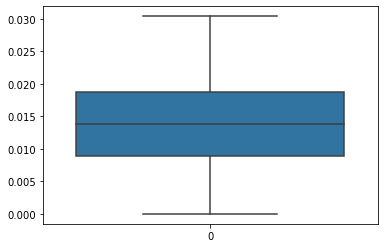

Authent Type
Batch                     335
CachedInteractive         164
InteractiveLogon          989
NetworkLogon            13080
RemoteInteractive         316
ScreensaverDismissed      472
ScreensaverInvoked        468
Service                   592
TGS                     15937
TGT                      3792
WorkstationLock          1134
WorkstationUnlock        1433
dtype: int64


In [32]:
simple_ae_eval(anomaly_bool_5,anomalies_ae_5,val_loss_5,set(rt_usernames),'red team')

We perform the same procedure for the sample of non red team usernames. Similarly the data is free to be imported whereas running the code will take roughly **56 minutes**.

In [33]:
try:
    print('Reading Data.')
    anomalies_ae_n_5 = pickle.load(open('Non RT Anomalies.p','rb'))
    val_loss_n_5 = pickle.load(open('Non RT VL.p','rb'))
    anomaly_bool_N_5 = []
    anomalies_ae_n_5 = anomalies_ae_n_5.drop_duplicates()

    for un in non_rt_sample:
        try:
            anomaly_bool_N_5.append((len(anomalies_ae_n_5[anomalies_ae_n_5['UserName'] == un]),un))
        except KeyError:
            anomaly_bool_N_5.append((0,un))
    clear_output()
    print('Data available.')
except:
    clear_output()
    print('Running AutoEncoder')
    frames_n_5 = []
    anomaly_bool_N_5 = []
    val_loss_n_5 = []
    bound = 400

    s_time = datetime.datetime.now()

    for i,un in enumerate(non_rt_sample):
        f,b,val = ae_anomaly_finder(un,24)
        if b == 1:
            frames_n_5.append(f)
            anomaly_bool_N_5.append((len(f),un))
            val_loss_n_5.append((val,un))
        else:
            anomaly_bool_N_5.append((0,un))
            val_loss_n_5.append((val,un))
            pass
    anomalies_ae_n_5 = pd.concat(frames_n_5)
    pickle.dump(anomalies_ae_n_5,open('Non RT Anomalies.p','wb'))
    pickle.dump(val_loss_n_5,open('Non RT VL.p','wb'))
    pickle.dump(non_rt_sample,open('Random Sample of Non Red Team Usernames.p','wb'))
    e_time = datetime.datetime.now()
    print(e_time-s_time)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00122: early stopping


C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:53:08.669887


We analyse the non red team sample results below.

179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
29.18% of the normal data was identified as anomalous.


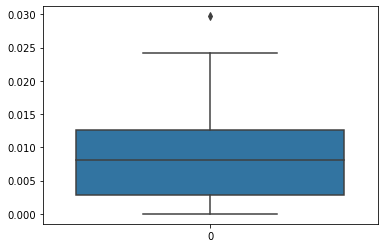

Authent Type
CachedInteractive          20
InteractiveLogon          465
NetworkLogon             9109
RemoteInteractive          60
ScreensaverDismissed      259
ScreensaverInvoked        252
Service                     4
TGS                     12631
TGT                      3188
WorkstationLock           641
WorkstationUnlock         864
dtype: int64


In [34]:
simple_ae_eval(anomaly_bool_N_5,anomalies_ae_n_5,val_loss_n_5,non_rt_sample,'normal')

Finally, we use our metrics to analyse the results.

In [93]:
MCC(94,21,179,1)

(array([38.98305085, 34.43223443, 98.94736842, 89.5       ]),
 0.16803315759376639)

#### Poisson AD

Here we run a Poisson anomaly detection algorithm.

Based on a gamma prior for a poisson distribution, we can estimate $ \lambda $ by $ \frac{(\sum{x_{i}} + \alpha)}{(n + \beta)}$. This is because under a $\Gamma(\alpha,\beta)$ prior for $\lambda$ we have that the posterior is $$ \pi(\lambda|x) \propto \lambda^{\sum{x_{i}}+\alpha-1} e^{-(n+\beta)\lambda}$$

This allows us to find anomalies based on the output of our poisson model.

In [114]:
def poiss_orig_finder(user,n,idx):
    
    j_idx = idx % n
    i_idx = int(idx/n)

    chunks = split_dataframe(authentication_data[auth_start_days[i_idx]:auth_start_days[i_idx+1]],n)
    data = chunks[j_idx][chunks[j_idx]['UserName'] == user]
    data['Hour'] = [j_idx]*len(data)
    data['Day'] = [i_idx+1]*len(data)
    
    return data

Here we define the Poisson anomaly detection model. We define the model with both the possibility to combine and not combine here.

In [115]:
def poiss_ae_detection(usernames,n,comb,alpha=1,beta=1):
    events_frames = []
    
    for (un_ct,un) in tqdm(enumerate(usernames)):

        pois_df = auth_type_un_df(un,n)
        bayes_mean = []
        bayes_var = []
        alpha = alpha
        beta = beta

        f_probs = []

        for col in pois_df.columns:
            dt = pois_df.iloc[:57*n][col]
            bayes_mean.append((alpha+sum(dt))/(beta+len(dt)))
            bayes_var.append((alpha+sum(dt))/(beta+len(dt))**2)

        probabilities = stats.poisson.pmf(pois_df.iloc[57*n:82*n],bayes_mean)
        
        if comb == True:
            for i in range(len(probabilities)):

                prob = probabilities[i]

                f_probs.append(stats.combine_pvalues(prob))
            for i in range(len(f_probs)):

                pv = f_probs[i][1]

                if pv <= 0.05:
                    events_frames.append(poiss_orig_finder(un,n,57*n+i))
        
        elif comb == False:
            for i in range(len(probabilities)):
                
                prob = probabilities[i]
                
                if any(prob <= 0.05):
                    events_frames.append(poiss_orig_finder(un,n,57*n+i))
        
    events = pd.concat(events_frames)
    return events

Here we define our analysis for the poisson anomaly detection model.

In [116]:
def simple_poiss_eval(anomaly_bools,anomalies,usernames,type_un):
    
    non_anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] == 0:    
            non_anom.append(anomaly_bools[i][1])

    anom = []
    for i in range(len(anomaly_bools)):
        if anomaly_bools[i][0] != 0:    
            anom.append(anomaly_bools[i][1])
    
    print('{} of the {} usernames were identified to have anomalies out of {} {} usernames. The folloiwng usernames were found to have no anomalies'.
          format(len(np.where(np.array([i[0] for i in anomaly_bools]) > 0)[0]),type_un,len(anomaly_bools),type_un))
    print('--------------------------------------------------------------------------------------------')        
    print(', '.join(map(str,non_anom)))
    
    perc = 100*len(anomalies)/len(authentication_data[authentication_data['UserName'].isin(usernames)])
    print('{:.2f}% of the {} data was identified as anomalous.'.format(perc,type_un))
    
    print(anomalies.groupby('Authent Type').size())
    
    anomalies.head()
    
    return

This block of code runs and analyses the models predictions on the red team data when combining results using Fisher's method. This was excluded from results due to a lack of applicability of Fisher's method however is left in to demonstrate our process.

In [117]:
s_time = datetime.datetime.now()
poisson_anoms = poiss_ae_detection(list(set(rt_usernames)),24,True)

poisson_anoms = poisson_anoms.drop_duplicates()
poiss_anom_bool = []

for un in rt_usernames:
    if un in list(poisson_anoms['UserName']):
        poiss_anom_bool.append((1,un))
    else:
        poiss_anom_bool.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)
simple_poiss_eval(poiss_anom_bool,poisson_anoms,list(set(rt_usernames)),'red team')

0it [00:00, ?it/s]

C:\Users\corri\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


0:07:52.090730
90 of the red team usernames were identified to have anomalies out of 99 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User133028, User702833, User859748, User457932, User829941, User405399, User900703, User497510, User222822
24.57% of the red team data was identified as anomalous.
Authent Type
Batch                     551
CachedInteractive         123
InteractiveLogon          968
NetworkLogon            12231
RemoteInteractive         350
ScreensaverDismissed      450
ScreensaverInvoked        432
Service                  1135
TGS                     14294
TGT                      4387
WorkstationLock          1082
WorkstationUnlock        1301
dtype: int64


This block of code runs and analyses the poisson model on the red team data when not combining.

In [118]:
s_time = datetime.datetime.now()
poisson_anoms_nc = poiss_ae_detection(list(set(rt_usernames)),24,False)

poisson_anoms_nc = poisson_anoms_nc.drop_duplicates()
poiss_anom_bool_nc = []

for un in rt_usernames:
    if un in list(poisson_anoms_nc['UserName']):
        poiss_anom_bool_nc.append((1,un))
    else:
        poiss_anom_bool_nc.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)
simple_poiss_eval(poiss_anom_bool_nc,poisson_anoms_nc,rt_usernames,'red team')

0it [00:00, ?it/s]

0:08:13.498438
98 of the red team usernames were identified to have anomalies out of 99 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
29.71% of the red team data was identified as anomalous.
Authent Type
Batch                     566
CachedInteractive         167
InteractiveLogon         1197
NetworkLogon            15676
RemoteInteractive         404
ScreensaverDismissed      482
ScreensaverInvoked        475
Service                  1136
TGS                     17599
TGT                      4778
WorkstationLock          1157
WorkstationUnlock        1461
dtype: int64


This block of code runs and analyses the poisson model for the non red team username sample when not combining.

In [119]:
s_time = datetime.datetime.now()

poisson_anoms_n = poiss_ae_detection(non_rt_sample,24,False)

poisson_anoms_n = poisson_anoms_n.drop_duplicates()
poiss_anom_bool_n = []

for un in non_rt_sample:
    if un in list(poisson_anoms_n['UserName']):
        poiss_anom_bool_n.append((1,un))
    else:  
        poiss_anom_bool_n.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)
simple_poiss_eval(poiss_anom_bool_n,poisson_anoms_n,non_rt_sample,'normal')

0it [00:00, ?it/s]

0:16:20.789294
179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
27.85% of the normal data was identified as anomalous.
Authent Type
CachedInteractive          20
InteractiveLogon          456
NetworkLogon             8397
RemoteInteractive          60
ScreensaverDismissed      259
ScreensaverInvoked        252
Service                     4
TGS                     12148
TGT                      3150
WorkstationLock           638
WorkstationUnlock         858
dtype: int64


Here we calculate the results of our process.

In [101]:
MCC(94,21,179,1)

(array([38.98305085, 34.43223443, 98.94736842, 89.5       ]),
 0.16803315759376639)

#### Inhomogenous Poisson AD

Here we define our 'inhomohenous' poisson model. For each day we calculate an independent poisson $ \lambda $.

In [102]:
def inhom_poiss_detection(usernames,n,comb,alpha=1,beta=100):
    events_frames = []
    
    for (un_ct,un) in enumerate(usernames):
        
        clear_output(wait=True)
        print('Working with username {} of {}. {:.2f} percentage complete.'.format(un_ct+1,len(usernames),100*((un_ct+1)/len(usernames))))
        pois_df = auth_type_un_df(un,n)
        bayes_mean = []
        bayes_var = []
        alpha = alpha
        beta = beta

        f_probs = []

        for i in range(n):
            bayes_mean_hr = []
            bayes_var_hr = []
            for col in pois_df.columns:
                dt = list(pd.concat([pois_df.iloc[:57*n],pois_df.iloc[83*n:]])[col])
                dt_hspl = dt[i::n]
                bayes_mean_hr.append((alpha+sum(dt_hspl))/(beta+len(dt_hspl)))
                bayes_var_hr.append((alpha+sum(dt_hspl))/(beta+len(dt_hspl))**2)

            bayes_mean.append(bayes_mean_hr)
            bayes_var.append(bayes_var_hr)
        
        find_prob = []
        for i in range(n):
            find_prob.append(pd.DataFrame(stats.poisson.pmf(pd.concat([pois_df.iloc[:57*n], pois_df.iloc[83*n:]]).iloc[i::n],bayes_mean[i])).min())
                
        probabilities = []
        
        for i in range(n):

            probabilities.append(stats.poisson.pmf(pois_df.iloc[57*n:82*n].iloc[i::n],bayes_mean[i]))

        for i in range(n):

            probs = probabilities[i]

            for j in range(len(probs)):

                hr_prob = probs[j]
                
                thresh = find_prob[i]
                
                if [item1 for item1,item2 in zip(hr_prob,thresh) if item1 <= item2] != []:

                    events_frames.append(poiss_orig_finder(un,n,57*n+j*n+i))

    events = pd.concat(events_frames)
    
    return events

Here we run our inhomogenous poisson model on the red team data.

In [103]:
s_time = datetime.datetime.now()
poisson_anoms_inhom = inhom_poiss_detection(rt_usernames,24,False)

poisson_anoms_inhom = poisson_anoms_inhom.drop_duplicates()
poiss_anom_bool_inhom = []

for un in rt_usernames:
    if un in list(poisson_anoms_inhom['UserName']):
        poiss_anom_bool_inhom.append((1,un))
    else:
        poiss_anom_bool_inhom.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)
simple_poiss_eval(poiss_anom_bool_inhom,poisson_anoms_inhom,rt_usernames,'red team')

Working with username 99 of 99. 100.00 percentage complete.
0:09:27.922954
98 of the red team usernames were identified to have anomalies out of 99 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
30.20% of the red team data was identified as anomalous.
Authent Type
Batch                     566
CachedInteractive         187
InteractiveLogon         1217
NetworkLogon            16197
RemoteInteractive         404
ScreensaverDismissed      484
ScreensaverInvoked        476
Service                  1136
TGS                     17771
TGT                      4782
WorkstationLock          1160
WorkstationUnlock        1467
dtype: int64


Here we run our inhomogenous model on the non-red team data.

In [104]:
s_time = datetime.datetime.now()

inhom_poisson_anoms_n = inhom_poiss_detection(non_rt_sample,24,False)

inhom_poisson_anoms_n = inhom_poisson_anoms_n.drop_duplicates()
inhom_poiss_anom_bool_n = []

for un in non_rt_sample:
    if un in list(inhom_poisson_anoms_n['UserName']):
        inhom_poiss_anom_bool_n.append((1,un))
    else:
        inhom_poiss_anom_bool_n.append((0,un))
e_time = datetime.datetime.now()
print(e_time-s_time)
simple_poiss_eval(inhom_poiss_anom_bool_n,inhom_poisson_anoms_n,non_rt_sample,'normal')

Working with username 200 of 200. 100.00 percentage complete.
0:18:53.111265
179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, User034060, Comp421434$, User681533, User658064, User108742, Comp282554$, Comp556020$, Comp834308$, Comp682953$, Comp156369$, User611055, User248771, User924320, Comp722112$, Comp360389$, Comp855953$
29.18% of the normal data was identified as anomalous.
Authent Type
CachedInteractive          20
InteractiveLogon          465
NetworkLogon             9109
RemoteInteractive          60
ScreensaverDismissed      259
ScreensaverInvoked        252
Service                     4
TGS                     12631
TGT                      3188
WorkstationLock           641
WorkstationUnlock         864
dtype: int64


In [105]:
MCC(94,21,179,1)

(array([38.98305085, 34.43223443, 98.94736842, 89.5       ]),
 0.16803315759376639)

#### Supervised Neural Network AD

Here we create our data for our supervised neural network data and turn the task of unsupervised anomaly detection into supervised anomaly detection. Similarly here, the original data can be imported (however not the results) but can also be run seperately. The code takes roughly **1 hour 13 minutes**.

In [140]:
try:
    print('Reading data.')
    nn_data = pd.read_csv('nn_supervised data.gz', compression='gzip')
    cols = list(nn_data.columns)
    cols.remove('Anomaly')
    X_train, X_test, y_train, y_test = train_test_split(nn_data[cols], nn_data['Anomaly'], test_size=0.1, random_state=42)
    X_train_un_list = list(X_train['UserName'])
    X_test_un_list = list(X_test['UserName'])
    X_train = X_train.drop('UserName',axis=1)
    X_test = X_test.drop('UserName',axis=1)
except:
    clear_output()
    print('Could not read data.')
    username_sample = list(pd.Series(rt_usernames).unique()) + non_rt_sample
    data = []
    for user in tqdm(username_sample):
        if user in rt_usernames:
            anom = 1
        else:
            anom = 0
        df = feature_generation_supervised(user,24,anom)
        data.append(df)
    nn_data = pd.concat(data)
    nn_data.to_csv('nn_supervised data.gz', compression='gzip')
    cols = list(nn_data.columns)
    cols.remove('Anomaly')
    X_train, X_test, y_train, y_test = train_test_split(nn_data[cols], nn_data['Anomaly'], test_size=0.1, random_state=42)
    X_train_un_list = list(X_train['UserName'])
    X_test_un_list = list(X_test['UserName'])
    X_train = X_train.drop('UserName',axis=1)
    X_test = X_test.drop('UserName',axis=1)

Could not read data.


  0%|          | 0/295 [00:00<?, ?it/s]

Here we define our neural network for this data. It is defined with dropout and dense layers using the 'elu' activation function.

In [141]:
def nn_anomaly_finder(x_train,x_test,y_train,y_test,train_user,test_user,n,BATCH_SIZE=256, EPOCHS=1000):
    
    # create our scaling pipeline
    pipeline = Pipeline([('normalizer', Normalizer()),
                    ('scaler', MinMaxScaler())])
    pipeline.fit(x_train)
    x_train = pipeline.transform(x_train)
    x_test = pipeline.transform(x_test)
    
    # define neural network parameters
    input_dim = x_train.shape[1]
    BATCH_SIZE = BATCH_SIZE
    EPOCHS = EPOCHS

    # define the nn
    neural_network =Sequential([

        tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(16, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(8, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(4, activation='elu'),
        tf.keras.layers.Dropout(rate=0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')

    ])

    # compile the autoencoder
    neural_network.compile(optimizer="adam", 
                        loss='binary_crossentropy',
                        metrics=["acc"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
    )
    
    # allows for early stopping and better visualisation of progress
    cb = [early_stop,TqdmCallback(verbose=1)]
    
    # fit the auto encoder
    history = neural_network.fit(
        x_train, y_train,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        verbose=0,
        callbacks=cb   
    )
    
    # make predictions on the remaining data
    x_test_pred = neural_network.predict(x_test)
    Y_pred = x_test_pred.argmax(axis=1)
    test_loss, test_acc = neural_network.evaluate(X_test, y_test)
    print(test_acc)
    
    anomalies = x_test[np.where(x_test_pred == 1)]
    #anomaly_idx = anomalies[0]
    
    #frame = []
    #for i in range(len(anomaly_idx)):
    #    user = test_user[anomaly_idx[i]]
    #    anomaly = nn_orig_finder(user,n,anomaly_idx[i])
        
        # indicates that an anomaly was found where we have no information i.e. the lack of an event was anomalous
    #    if len(anomaly) == 0:
    #        pass
    #    else:
    #        frame.append(anomaly)
    #    
    #if len(frame) != 0:
    #    anomaly_df = pd.concat(frame)
    #    return anomaly_df,1,history.history["val_loss"]
    #else:
    #    print('No anomalies found.')
    #    return pd.DataFrame(test_mae_loss).describe(),0,history.history["val_loss"]
    return Y_pred

In [142]:
Y_pred = nn_anomaly_finder(X_train,X_test,y_train,y_test,X_train_un_list,X_test_un_list,24,BATCH_SIZE=256, EPOCHS=1000)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
1992/1992 [==============================] - 2s 667us/step - loss: 0.9058 - acc: 0.9001
0.9001255631446838


We define a classification evaluation function for our neural network here including a classification matrix and report.

In [143]:
def classification_eval(y_pred,df_test_resp):
    dec = np.int64(np.ceil(np.log10(len(df_test_resp))))
    
    print("Confusion Matrix")
    print(confusion_matrix(df_test_resp,y_pred),'\n')
    
    print('Classification report')
    print(classification_report(df_test_resp, y_pred, digits=dec))
    
    print("Scalar Metrics")
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('MCC', matthews_corrcoef(df_test_resp, y_pred)))
    print(format_str % ("Cohen's kappa", cohen_kappa_score(df_test_resp, y_pred)))
    print(format_str % ('Accuracy', accuracy_score(df_test_resp, y_pred)))

In [144]:
classification_eval(Y_pred,y_test)

Confusion Matrix
[[57862     0]
 [ 5858     0]] 

Classification report
              precision    recall  f1-score   support

           0    0.90807   1.00000   0.95182     57862
           1    0.00000   0.00000   0.00000      5858

    accuracy                        0.90807     63720
   macro avg    0.45403   0.50000   0.47591     63720
weighted avg    0.82458   0.90807   0.86431     63720

Scalar Metrics
          MCC = 0.00000
Cohen's kappa = 0.00000
     Accuracy = 0.90807


C:\Users\corri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\corri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\corri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\corri\anaconda3\lib\site-packages\sklearn\metr

Despite the apearance of good precision, the results are poor with no anomalies detected.

#### ASE AD

For this we need to know which data is red team and which is normal, we do this here.

In [145]:
a = []
for i in columns_sparse:
    b = i in list(rt_usernames)
    a.append(b)
idx = [i for i,x in enumerate(a) if x == True]

Here we implement the ASE function based on - https://arxiv.org/pdf/2008.10055.pdf, https://jscholarship.library.jhu.edu/bitstream/handle/1774.2/37075/SUSSMAN-DISSERTATION-2014.pdf

In [146]:
def ASE_anom_finder(window_length):

    vertex_norm_tracker = []
    graph_norm_tracker = []

    graph_mam_tracker = []
    graph_range_tracker = []

    vertex_mam_tracker = []
    vertex_range_tracker = []

    for t in tqdm(range(len(data_frame_list_uase)-1)):
        u1, s1, v1 = scipy.sparse.linalg.svds(data_frame_list_uase[t],k=7)
        u2, s2, v2 = scipy.sparse.linalg.svds(data_frame_list_uase[t+1],k=7)
        Y1 = pd.DataFrame((v1.transpose()*s1**0.5).transpose(),columns=(list(set(columns_sparse))))
        Y2 = pd.DataFrame((v2.transpose()*s2**0.5).transpose(),columns=(list(set(columns_sparse))))

        nrm = scipy.linalg.norm(Y2-Y1,ord=2)
        graph_norm_tracker.append(nrm)

        vertex_norms = []
        for v in list(columns_sparse):
            nrm = scipy.linalg.norm(Y2[v]-Y1[v],ord=2)
            vertex_norms.append(nrm)

        vertex_norm_tracker.append(vertex_norms)

        if t >= window_length:
            graph_mam = np.sum(graph_norm_tracker[(t-window_length+1):t-1])/(window_length-1)
            graph_range = np.sum(np.linalg.norm(np.array(graph_norm_tracker[t-window_length+2:t-1])-np.array(graph_norm_tracker[t-window_length+1:t-2])))/(1.128*(window_length-2))
            graph_mam_tracker.append(graph_mam)
            graph_range_tracker.append(graph_range)

            vertex_mam_tracker_day = []
            vertex_range_tracker_day = []

            for j in range(len(list(columns_sparse))):
                vertex_mam = np.sum([vertex_norm_tracker[k][j] for k in range(t-window_length+1,t)])/(window_length-1)
                vertex_mam_tracker_day.append(vertex_mam)
                vertex_range = np.sqrt((vertex_mam*(1-vertex_mam))/(window_length-1))
                #vertex_range = np.std([vertex_norm_tracker[k][j] for k in range(t-window_length+1,t)])/(window_length-1)
                vertex_range_tracker_day.append(vertex_range)
            vertex_mam_tracker.append(vertex_mam_tracker_day)
            vertex_range_tracker.append(vertex_range_tracker_day)

    day_anomalies = []

    for i,v in enumerate(list(columns_sparse)):
        y_v = np.array([vertex_norm_tracker[k][i] for k in range(len(vertex_norm_tracker))])
        ucl_v = np.array([vertex_mam_tracker[k][i] for k in range(len(vertex_mam_tracker))])+3*np.array([vertex_range_tracker[k][i] for k in range(len(vertex_range_tracker))])
        anomalies = [j+window_length+1 for j,y in enumerate(y_v[window_length:]) if y > ucl_v[j]]
        if len(anomalies) > 0:
            day_anomalies.append((v,anomalies))
        
    return vertex_norm_tracker, graph_norm_tracker, graph_mam_tracker, graph_range_tracker, vertex_mam_tracker, vertex_range_tracker, day_anomalies

We call our function for sliding windows of lengths: 14, 7, 5, 3, 2.

In [147]:
vertex_norm_tracker_14, graph_norm_tracker_14, graph_mam_tracker_14, graph_range_tracker_14, vertex_mam_tracker_14, vertex_range_tracker_14, day_anomalies_14 = ASE_anom_finder(14)
vertex_norm_tracker_7, graph_norm_tracker_7, graph_mam_tracker_7, graph_range_tracker_7, vertex_mam_tracker_7, vertex_range_tracker_7, day_anomalies_7 = ASE_anom_finder(7)
vertex_norm_tracker_5, graph_norm_tracker_5, graph_mam_tracker_5, graph_range_tracker_5, vertex_mam_tracker_5, vertex_range_tracker_5, day_anomalies_5 = ASE_anom_finder(5)
vertex_norm_tracker_3, graph_norm_tracker_3, graph_mam_tracker_3, graph_range_tracker_3, vertex_mam_tracker_3, vertex_range_tracker_3, day_anomalies_3 = ASE_anom_finder(3)
vertex_norm_tracker_2, graph_norm_tracker_2, graph_mam_tracker_2, graph_range_tracker_2, vertex_mam_tracker_2, vertex_range_tracker_2, day_anomalies_2 = ASE_anom_finder(2)

  0%|          | 0/89 [00:00<?, ?it/s]

<ipython-input-146-f4939e4061e8>:40: RuntimeWarning: invalid value encountered in sqrt
  vertex_range = np.sqrt((vertex_mam*(1-vertex_mam))/(window_length-1))


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

<ipython-input-146-f4939e4061e8>:30: RuntimeWarning: invalid value encountered in double_scalars
  graph_range = np.sum(np.linalg.norm(np.array(graph_norm_tracker[t-window_length+2:t-1])-np.array(graph_norm_tracker[t-window_length+1:t-2])))/(1.128*(window_length-2))


This is a quick look at how many anomalies we detect (how many usernames have anomalies).

We also produce plots of the data here.

In [148]:
def plot_creation(window_length,vertex_mam_tracker,vertex_range_tracker,vertex_norm_tracker,u):
    
    plt.figure(figsize = (16,8))  
    plt.plot(np.arange(window_length,len(data_frame_list_uase)-1),[vertex_mam_tracker[k][u] for k in range(len(vertex_mam_tracker))])
    plt.plot(np.arange(window_length,len(data_frame_list_uase)-1),np.array([vertex_mam_tracker[k][u] for k in range(len(vertex_mam_tracker))])+3*np.array([vertex_range_tracker[k][u] for k in range(len(vertex_range_tracker))]),'--')
    plt.plot([vertex_norm_tracker[k][u] for k in range(len(vertex_norm_tracker))],'r.')
    plt.xlabel('Day')
    plt.ylabel('$||{X_{i}^{(t+1)}-X_{i}^{(t)}}||$')
    plt.title('Window Length: {}'.format(window_length))
    plt.show()
    
    return

The below code plots this for the entire graph.

In [149]:
def graph_plot_creation(window_length,graph_mam_tracker,graph_range_tracker,graph_norm_tracker):
    
    plt.figure(figsize=(16,8))
    plt.plot(np.arange(window_length,len(graph_mam_tracker)+window_length),graph_mam_tracker)
    plt.plot(np.arange(window_length,len(graph_mam_tracker)+window_length),np.array(graph_mam_tracker) + 3 * np.array(graph_range_tracker))
    plt.plot(graph_norm_tracker,'r.')
    plt.xlabel('Day')
    plt.ylabel('$||X^{(t+1)}-X^{(t)}||$')
    plt.title('Window Length: {}'.format(window_length))
    plt.show()
    
    return

We now plot the entire graph results.

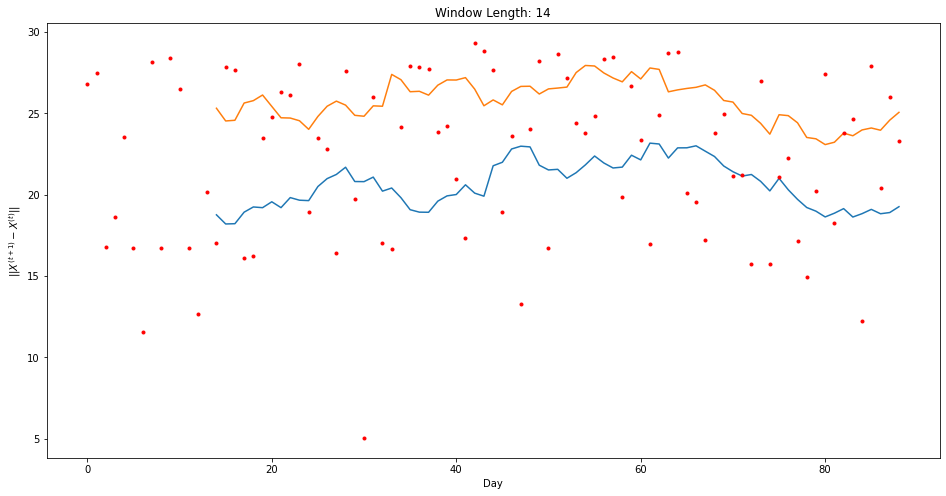

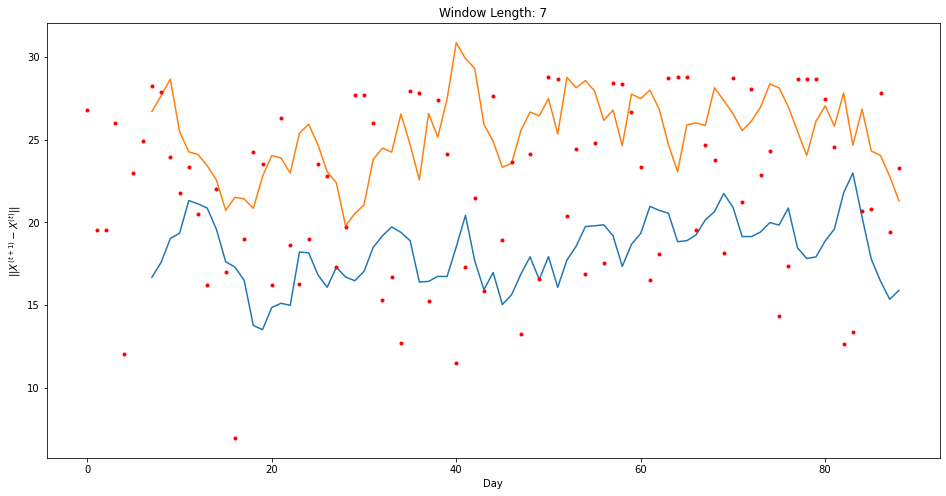

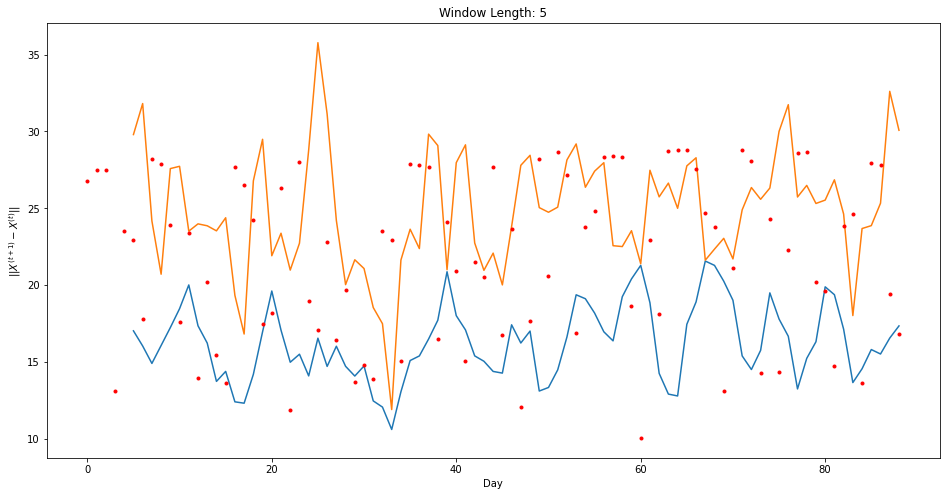

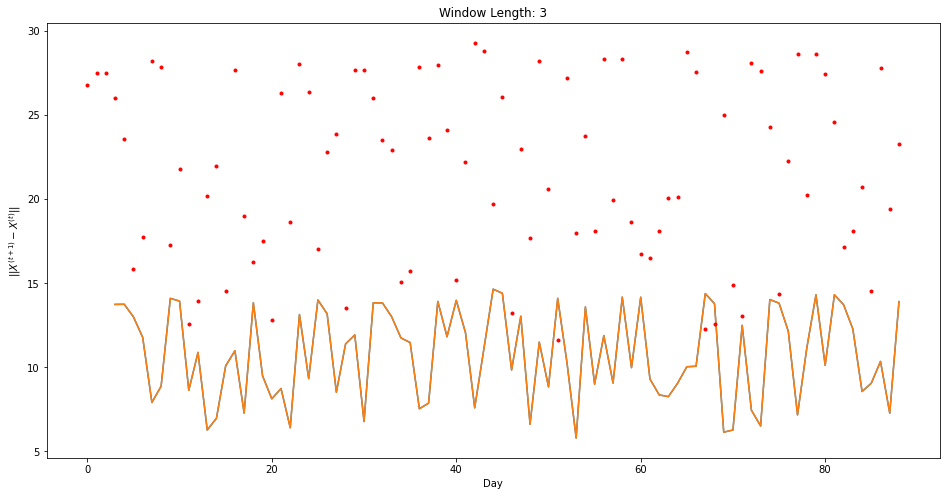

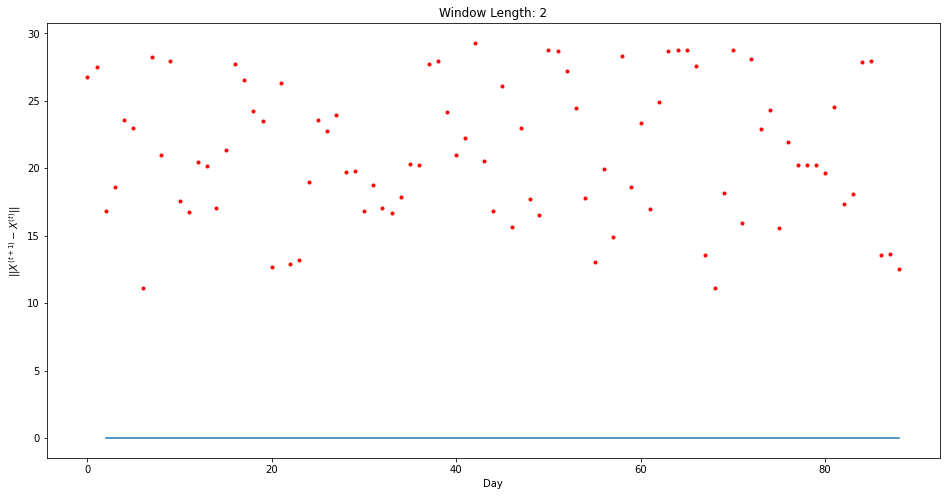

In [150]:
graph_plot_creation(14,graph_mam_tracker_14,graph_range_tracker_14,graph_norm_tracker_14)
graph_plot_creation(7,graph_mam_tracker_7,graph_range_tracker_7,graph_norm_tracker_7)
graph_plot_creation(5,graph_mam_tracker_5,graph_range_tracker_5,graph_norm_tracker_5)
graph_plot_creation(3,graph_mam_tracker_3,graph_range_tracker_3,graph_norm_tracker_3)
graph_plot_creation(2,graph_mam_tracker_2,graph_range_tracker_2,graph_norm_tracker_2)

The below code finds a red team user and plots it.

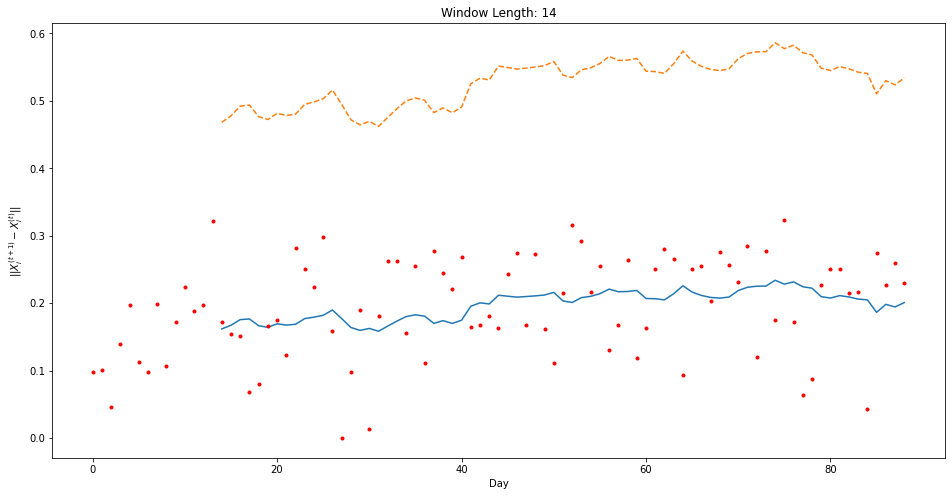

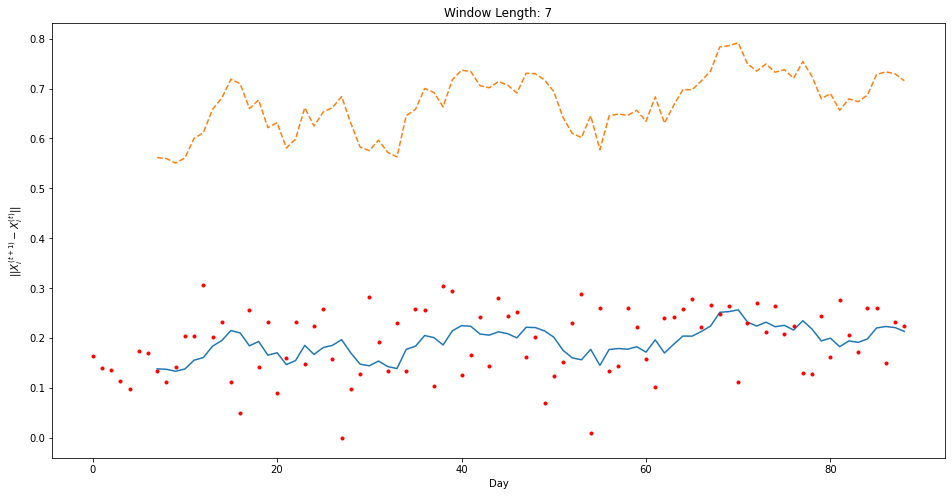

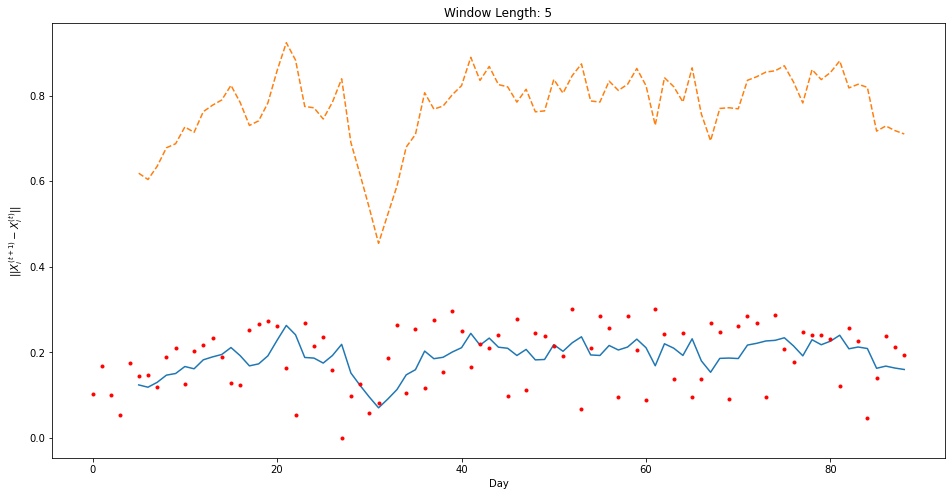

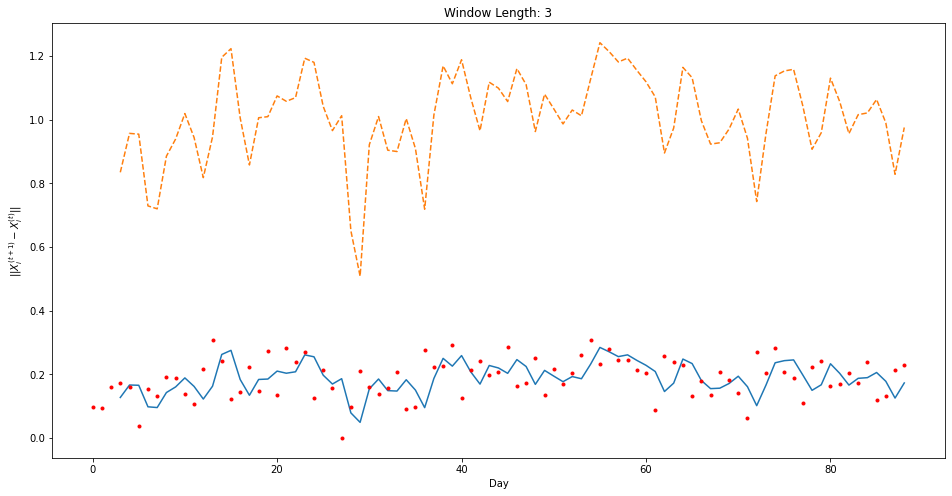

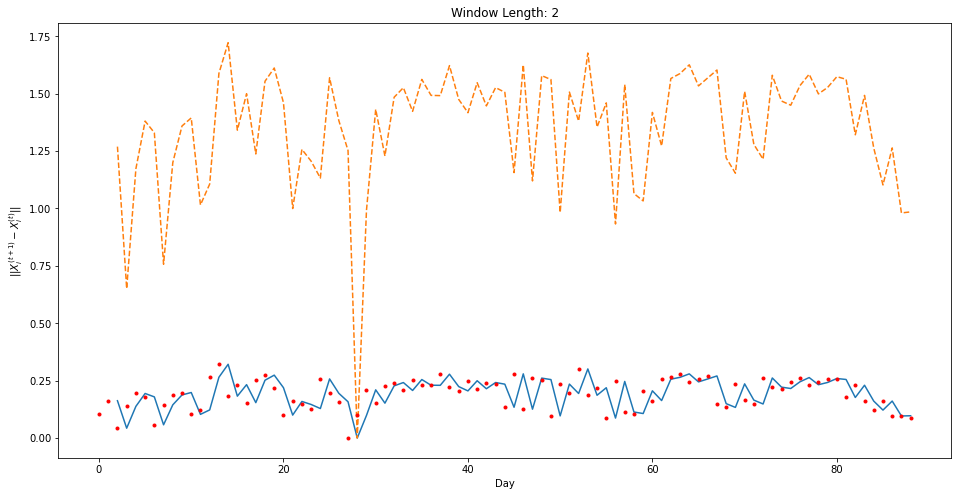

In [151]:
rt_user_idx = []
for i,un in enumerate(columns_sparse):
    b = un in list(rt_usernames)
    if b == True:
        rt_user_idx.append(i)

plot_creation(14,vertex_mam_tracker_14,vertex_range_tracker_14,vertex_norm_tracker_14,rt_user_idx[0])
plot_creation(7,vertex_mam_tracker_7,vertex_range_tracker_7,vertex_norm_tracker_7,rt_user_idx[0])
plot_creation(5,vertex_mam_tracker_5,vertex_range_tracker_5,vertex_norm_tracker_5,rt_user_idx[0])
plot_creation(3,vertex_mam_tracker_3,vertex_range_tracker_3,vertex_norm_tracker_3,rt_user_idx[0])
plot_creation(2,vertex_mam_tracker_2,vertex_range_tracker_2,vertex_norm_tracker_2,rt_user_idx[0])

Here we define a function to allow us to look into the results and determine how many of each type of username is identified correcly.

In [152]:
def anomaly_count_rt(day_anomalies,day):
    anomaly_users = []
    for i in range(len(day_anomalies)):
        anomaly_users.append(day_anomalies[i][0])

    rt_ct = 0
    for un in set(rt_usernames):
        if un in anomaly_users:
            rt_ct += 1
            
    n_ct = 0
    for un in set(rt_usernames) ^ set(list(columns_sparse)):
        if un in anomaly_users:
            n_ct += 1
    
    print('Using a sliding window of length {} captures {}% of rt users as anomalous and {}% of normal users as anomalous.'.format(day,rt_ct/len(set(rt_usernames)),(n_ct/len(set(rt_usernames) ^ set(list(columns_sparse))))))
    print('Using a sliding window of length {} captures {} of {} rt users as anomalous and {} of {} normal users as anomalous.'.format(day,rt_ct,len(set(rt_usernames)),n_ct,len(set(rt_usernames) ^ set(list(columns_sparse)))))
    
    return

In [153]:
anomaly_count_rt(day_anomalies_14,14)
anomaly_count_rt(day_anomalies_7,7)
anomaly_count_rt(day_anomalies_5,5)
anomaly_count_rt(day_anomalies_3,3)
anomaly_count_rt(day_anomalies_2,2)

Using a sliding window of length 14 captures 0.3263157894736842% of rt users as anomalous and 0.37893454038997215% of normal users as anomalous.
Using a sliding window of length 14 captures 31 of 95 rt users as anomalous and 10883 of 28720 normal users as anomalous.
Using a sliding window of length 7 captures 0.4% of rt users as anomalous and 0.42089136490250695% of normal users as anomalous.
Using a sliding window of length 7 captures 38 of 95 rt users as anomalous and 12088 of 28720 normal users as anomalous.
Using a sliding window of length 5 captures 0.5157894736842106% of rt users as anomalous and 0.4943593314763231% of normal users as anomalous.
Using a sliding window of length 5 captures 49 of 95 rt users as anomalous and 14198 of 28720 normal users as anomalous.
Using a sliding window of length 3 captures 0.7263157894736842% of rt users as anomalous and 0.6678272980501393% of normal users as anomalous.
Using a sliding window of length 3 captures 69 of 95 rt users as anomalous a

And we finally analyse these results using our metrics.

In [154]:
print(MCC(42,28720-16859,16859,53))
print(MCC(61,28720-20868,20868,34))
print(MCC(65,28720-23840,23840,30))
print(MCC(93,28720-28240,28240,2))
print(MCC(95,28720-28567,28567,0))

(array([41.30834635,  0.24850601, 44.21052632, 58.70125348]), -0.016867829449985956)
(array([27.46139164,  0.29146161, 64.21052632, 72.66016713]), -0.0108639971506521)
(array([17.16120076,  0.27190964, 68.42105263, 83.00835655]), -0.022240468503002247)
(array([ 1.98854763,  0.32823916, 97.89473684, 98.32869081]), -0.0019396701483567773)
(array([  0.86066285,   0.33144931, 100.        ,  99.46727019]), 0.004202058114758256)


We re-run this, using a mean and range defined by the period we know to be normal i.e. the first 56 days. These results however are not included in the final document due to the lack of accuracy.

In [155]:
def ASE_anom_finder_normal(window_length=56):

    vertex_norm_tracker = []
    graph_norm_tracker = []

    graph_mam_tracker = []
    graph_range_tracker = []

    vertex_mam_tracker = []
    vertex_range_tracker = []

    for t in tqdm(range(len(data_frame_list_uase)-1)):
        u1, s1, v1 = scipy.sparse.linalg.svds(data_frame_list_uase[t],k=7)
        u2, s2, v2 = scipy.sparse.linalg.svds(data_frame_list_uase[t+1],k=7)
        Y1 = pd.DataFrame((v1.transpose()*s1**0.5).transpose(),columns=(list(set(columns_sparse))))
        Y2 = pd.DataFrame((v2.transpose()*s2**0.5).transpose(),columns=(list(set(columns_sparse))))

        nrm = scipy.linalg.norm(Y2-Y1,ord=2)
        graph_norm_tracker.append(nrm)

        vertex_norms = []
        for v in list(columns_sparse):
            nrm = scipy.linalg.norm(Y2[v]-Y1[v],ord=2)
            vertex_norms.append(nrm)

        vertex_norm_tracker.append(vertex_norms)

        if t == window_length:
            graph_mam = np.sum(graph_norm_tracker[(t-window_length+1):t-1])/(window_length-1)
            graph_range = np.sum(np.linalg.norm(np.array(graph_norm_tracker[t-window_length+2:t-1])-np.array(graph_norm_tracker[t-window_length+1:t-2])))/(1.128*(window_length-2))
            graph_mam_tracker.append(graph_mam)
            graph_range_tracker.append(graph_range)

            vertex_mam_tracker_day = []
            vertex_range_tracker_day = []

            for j in range(len(list(columns_sparse))):
                vertex_mam = np.sum([vertex_norm_tracker[k][j] for k in range(t-window_length+1,t)])/(window_length-1)
                vertex_mam_tracker_day.append(vertex_mam)
                vertex_range = np.sqrt((vertex_mam*(1-vertex_mam))/(window_length-1))
                vertex_range_tracker_day.append(vertex_range)
            vertex_mam_tracker.append(vertex_mam_tracker_day)
            vertex_range_tracker.append(vertex_range_tracker_day)
        elif t > window_length:
            graph_mam_tracker.append(graph_mam_tracker[0])
            graph_range_tracker.append(graph_range_tracker[0])
            vertex_mam_tracker.append(vertex_mam_tracker[0])
            vertex_range_tracker.append(vertex_range_tracker[0])
    day_anomalies = []

    for i,v in enumerate(list(columns_sparse)):
        y_v = np.array([vertex_norm_tracker[k][i] for k in range(len(vertex_norm_tracker))])
        ucl_v = np.array([vertex_mam_tracker[k][i] for k in range(len(vertex_mam_tracker))])+3*np.array([vertex_range_tracker[k][i] for k in range(len(vertex_range_tracker))])
        anomalies = [j+window_length+1 for j,y in enumerate(y_v[window_length:]) if y > ucl_v[j]]
        if len(anomalies) > 0:
            day_anomalies.append((v,anomalies))
        
    return vertex_norm_tracker, graph_norm_tracker, graph_mam_tracker, graph_range_tracker, vertex_mam_tracker, vertex_range_tracker, day_anomalies

In [156]:
vertex_norm_tracker_normal, graph_norm_tracker_normal, graph_mam_tracker_normal, graph_range_tracker_normal, vertex_mam_tracker_normal, vertex_range_tracker_normal, day_anomalies_normal = ASE_anom_finder_normal()

  0%|          | 0/89 [00:00<?, ?it/s]

<ipython-input-155-87c9bcc8c996>:40: RuntimeWarning: invalid value encountered in sqrt
  vertex_range = np.sqrt((vertex_mam*(1-vertex_mam))/(window_length-1))


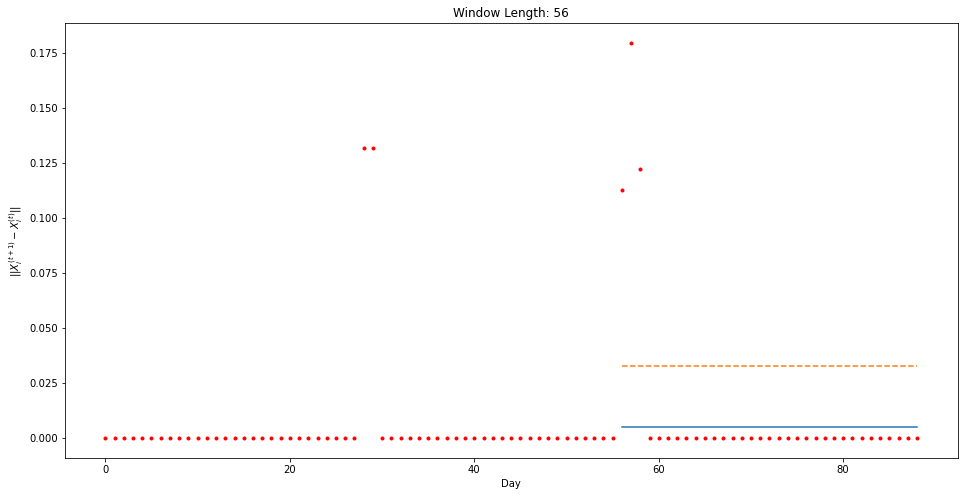

In [157]:
plot_creation(56,vertex_mam_tracker_normal,vertex_range_tracker_normal,vertex_norm_tracker_normal,23991)

In [158]:
anomaly_count_rt(day_anomalies_normal,56)

Using a sliding window of length 56 captures 0.49473684210526314% of rt users as anomalous and 0.4578690807799443% of normal users as anomalous.
Using a sliding window of length 56 captures 47 of 95 rt users as anomalous and 13150 of 28720 normal users as anomalous.


In [159]:
print(MCC(45,28720-13720,13720,50))

(array([52.21238938,  0.32691609, 47.36842105, 47.77158774]), -0.0004626816832603691)


#### UASE Implementation

Finally, we implement the UASE technique for decomposition and re-do our graph analysis.

In [160]:
def UASE_anom_finder(window_length):

    vertex_norm_tracker = []
    graph_norm_tracker = []

    graph_mam_tracker = []
    graph_range_tracker = []

    vertex_mam_tracker = []
    vertex_range_tracker = []

    weeks = int(len(data_frame_list_uase)/window_length)
    Y_arrays = []

    for i in range(weeks):
        matrices = []
        for j in range(window_length):
            matrices.append(data_frame_list_uase[i*window_length+j])

        wl_matrix = scipy.sparse.hstack(matrices)

        u, s, v = scipy.sparse.linalg.svds(wl_matrix.asfptype(),k=7)

        for j in range(window_length):
            v_j = pd.DataFrame(v).iloc[: ,28815*j:28815*(j+1)]
            Y = pd.DataFrame((v_j.transpose()*s**0.5).transpose())
            Y_arrays.append(Y)

    for t in tqdm(range(len(Y_arrays)-1)):
        
        Y2 = Y_arrays[t+1]
        Y1 = Y_arrays[t]
        nrm = scipy.linalg.norm(np.subtract(Y2,Y1),ord=2)
        graph_norm_tracker.append(nrm)

        vertex_norms = []
        
        for i,v in enumerate(list(columns_sparse)):
            nrm = scipy.linalg.norm(np.subtract(Y2.iloc[:,i],Y1.iloc[:,i]),ord=2)
            vertex_norms.append(nrm)

        vertex_norm_tracker.append(vertex_norms)

        if t >= window_length:
            graph_mam = np.sum(graph_norm_tracker[(t-window_length+1):t-1])/(window_length-1)
            graph_range = np.sum(np.linalg.norm(np.array(graph_norm_tracker[t-window_length+2:t-1])-np.array(graph_norm_tracker[t-window_length+1:t-2])))/(1.128*(window_length-2))
            graph_mam_tracker.append(graph_mam)
            graph_range_tracker.append(graph_range)

            vertex_mam_tracker_day = []
            vertex_range_tracker_day = []

            for j in range(len(list(columns_sparse))):
                vertex_mam = np.sum([vertex_norm_tracker[k][j] for k in range(t-window_length+1,t)])/(window_length-1)
                vertex_mam_tracker_day.append(vertex_mam)
                vertex_range = np.sqrt((vertex_mam*(1-vertex_mam))/(window_length-1))
                vertex_range_tracker_day.append(vertex_range)
            vertex_mam_tracker.append(vertex_mam_tracker_day)
            vertex_range_tracker.append(vertex_range_tracker_day)

    day_anomalies = []

    for i,v in enumerate(list(columns_sparse)):
        y_v = np.array([vertex_norm_tracker[k][i] for k in range(len(vertex_norm_tracker))])
        ucl_v = np.array([vertex_mam_tracker[k][i] for k in range(len(vertex_mam_tracker))])+3*np.array([vertex_range_tracker[k][i] for k in range(len(vertex_range_tracker))])
        anomalies = [j+window_length+1 for j,y in enumerate(y_v[window_length:]) if y > ucl_v[j]]
        if len(anomalies) > 0:
            day_anomalies.append((v,anomalies))
        
    return vertex_norm_tracker, graph_norm_tracker, graph_mam_tracker, graph_range_tracker, vertex_mam_tracker, vertex_range_tracker, day_anomalies

In [161]:
vertex_norm_tracker_7, graph_norm_tracker_7, graph_mam_tracker_7, graph_range_tracker_7, vertex_mam_tracker_7, vertex_range_tracker_7, day_anomalies_7_U = UASE_anom_finder(7)
vertex_norm_tracker_14, graph_norm_tracker_14, graph_mam_tracker_14, graph_range_tracker_14, vertex_mam_tracker_14, vertex_range_tracker_14, day_anomalies_14_U = UASE_anom_finder(14)
vertex_norm_tracker_3, graph_norm_tracker_3, graph_mam_tracker_3, graph_range_tracker_3, vertex_mam_tracker_3, vertex_range_tracker_3, day_anomalies_3_U = UASE_anom_finder(3)
vertex_norm_tracker_2, graph_norm_tracker_2, graph_mam_tracker_2, graph_range_tracker_2, vertex_mam_tracker_2, vertex_range_tracker_2, day_anomalies_2_U = UASE_anom_finder(2)
vertex_norm_tracker_5, graph_norm_tracker_5, graph_mam_tracker_5, graph_range_tracker_5, vertex_mam_tracker_5, vertex_range_tracker_5, day_anomalies_5_U = UASE_anom_finder(5)

  0%|          | 0/83 [00:00<?, ?it/s]

<ipython-input-160-a2d49b8a1c71>:33: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  nrm = scipy.linalg.norm(np.subtract(Y2,Y1),ord=2)
<ipython-input-160-a2d49b8a1c71>:56: RuntimeWarning: invalid value encountered in sqrt
  vertex_range = np.sqrt((vertex_mam*(1-vertex_mam))/(window_length-1))


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

<ipython-input-160-a2d49b8a1c71>:46: RuntimeWarning: invalid value encountered in double_scalars
  graph_range = np.sum(np.linalg.norm(np.array(graph_norm_tracker[t-window_length+2:t-1])-np.array(graph_norm_tracker[t-window_length+1:t-2])))/(1.128*(window_length-2))


  0%|          | 0/89 [00:00<?, ?it/s]

In [162]:
def plot_creation_UASE(window_length,vertex_mam_tracker,vertex_range_tracker,vertex_norm_tracker,u,vertex=True):

    plt.figure(figsize = (16,8))  
    plt.plot(np.arange(window_length,len(data_frame_list_uase)-1-(len(data_frame_list_uase)%window_length)),[vertex_mam_tracker[k][u] for k in range(len(vertex_mam_tracker))])
    plt.plot(np.arange(window_length,len(data_frame_list_uase)-1-(len(data_frame_list_uase)%window_length)),np.array([vertex_mam_tracker[k][u] for k in range(len(vertex_mam_tracker))])+3*np.array([vertex_range_tracker[k][u] for k in range(len(vertex_range_tracker))]),'--')
    plt.plot([vertex_norm_tracker[k][u] for k in range(len(vertex_norm_tracker))],'r.')
    plt.xlabel('Day')
    plt.ylabel('$||{X_{i}^{(t+1)}-X_{i}^{(t)}}||$')
    plt.title('Window Length: {}'.format(window_length))
    plt.show()
    

    return

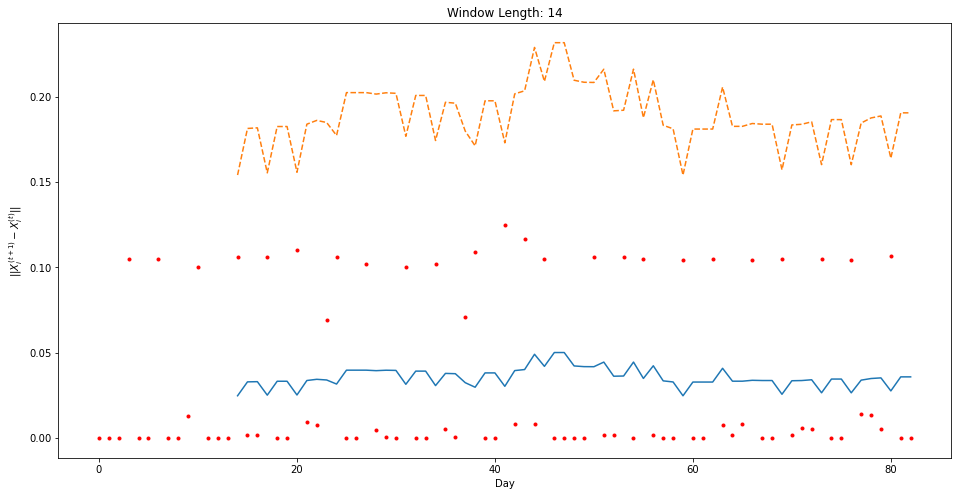

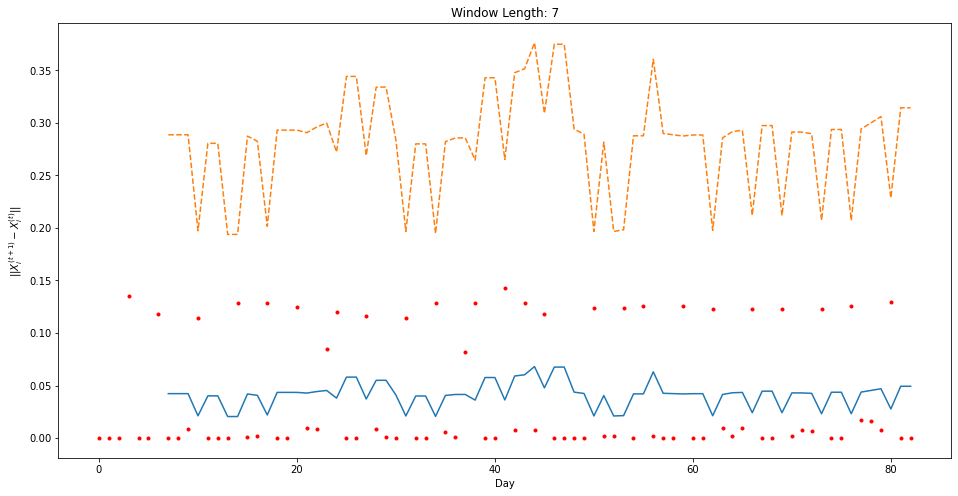

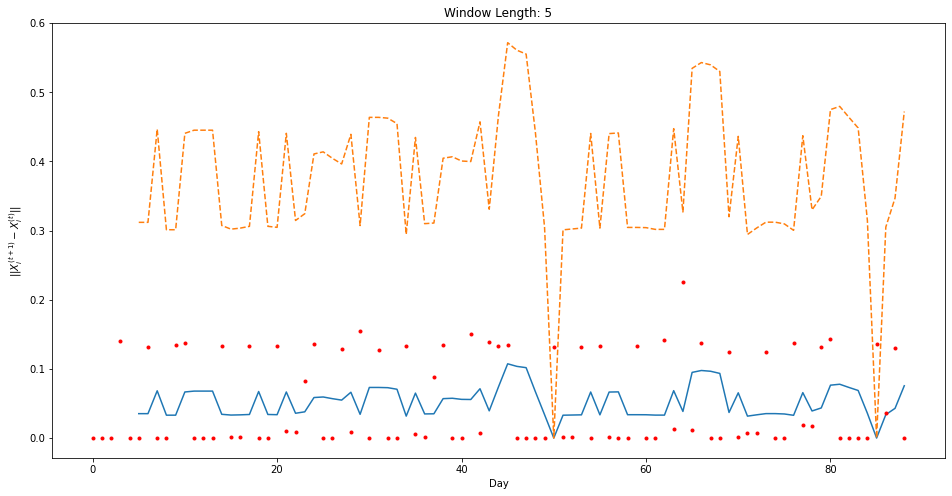

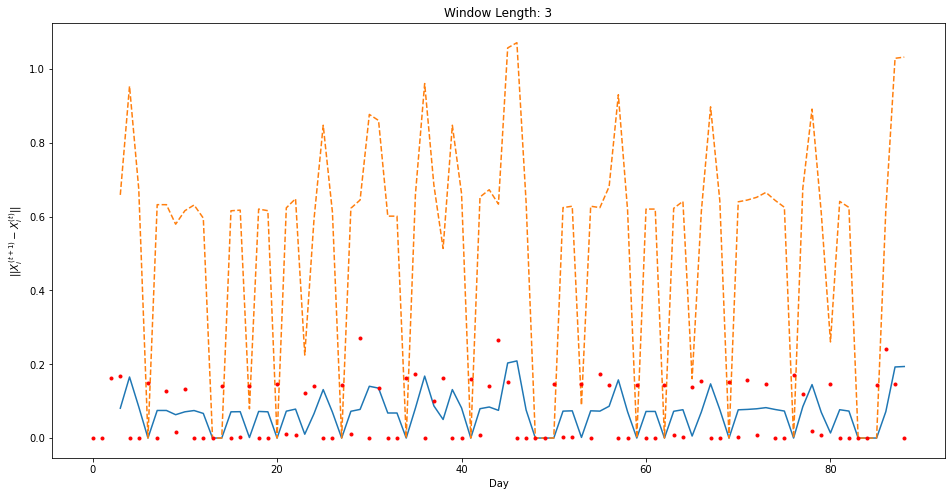

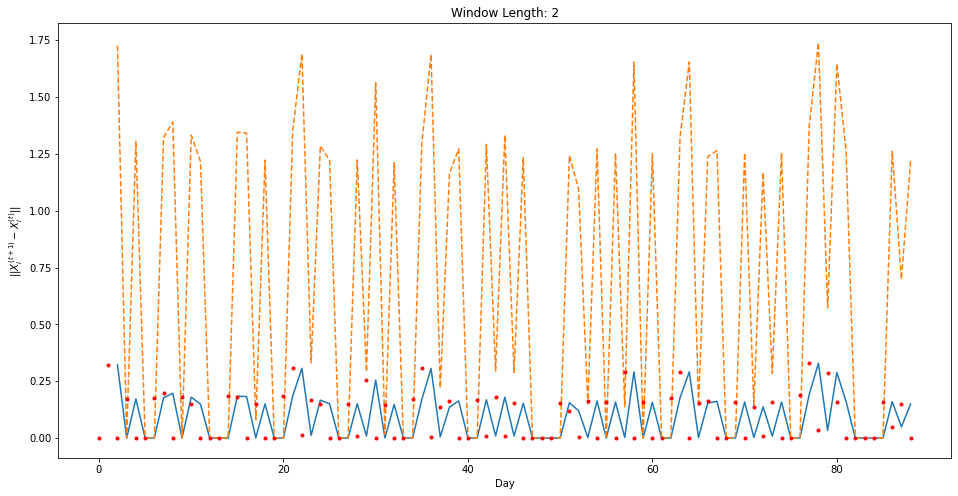

In [163]:
plot_creation_UASE(14,vertex_mam_tracker_14,vertex_range_tracker_14,vertex_norm_tracker_14,idx[1])
plot_creation_UASE(7,vertex_mam_tracker_7,vertex_range_tracker_7,vertex_norm_tracker_7,idx[1])
plot_creation_UASE(5,vertex_mam_tracker_5,vertex_range_tracker_5,vertex_norm_tracker_5,idx[1])
plot_creation_UASE(3,vertex_mam_tracker_3,vertex_range_tracker_3,vertex_norm_tracker_3,idx[1])
plot_creation_UASE(2,vertex_mam_tracker_2,vertex_range_tracker_2,vertex_norm_tracker_2,idx[1])

In [164]:
anomaly_count_rt(day_anomalies_14_U,14)
anomaly_count_rt(day_anomalies_7_U,7)
anomaly_count_rt(day_anomalies_5_U,5)
anomaly_count_rt(day_anomalies_3_U,3)
anomaly_count_rt(day_anomalies_2_U,2)

Using a sliding window of length 14 captures 0.6% of rt users as anomalous and 0.659958217270195% of normal users as anomalous.
Using a sliding window of length 14 captures 57 of 95 rt users as anomalous and 18954 of 28720 normal users as anomalous.
Using a sliding window of length 7 captures 0.631578947368421% of rt users as anomalous and 0.7229108635097493% of normal users as anomalous.
Using a sliding window of length 7 captures 60 of 95 rt users as anomalous and 20762 of 28720 normal users as anomalous.
Using a sliding window of length 5 captures 0.6526315789473685% of rt users as anomalous and 0.8227715877437326% of normal users as anomalous.
Using a sliding window of length 5 captures 62 of 95 rt users as anomalous and 23630 of 28720 normal users as anomalous.
Using a sliding window of length 3 captures 0.9578947368421052% of rt users as anomalous and 0.9841922005571031% of normal users as anomalous.
Using a sliding window of length 3 captures 91 of 95 rt users as anomalous and 2

In [165]:
print(MCC(50,28720-18460,18460,45))
print(MCC(42,28720-19405,19405,53))
print(MCC(65,28720-23900,23900,30))
print(MCC(92,28720-28291,28291,3))
print(MCC(95,28720-28567,28567,0))

(array([35.77997571,  0.27012426, 52.63157895, 64.27576602]), -0.013926307710791378)
(array([32.47267048,  0.21597162, 44.21052632, 67.56615599]), -0.028582213093000287)
(array([16.95297588,  0.27122888, 68.42105263, 83.21727019]), -0.022669667119785533)
(array([ 1.80808607,  0.32413769, 96.84210526, 98.50626741]), -0.007850162332786662)
(array([  0.86066285,   0.33144931, 100.        ,  99.46727019]), 0.004202058114758256)


#### UMAP Visualisations of UASE

UMAP allows us to perform dimensionality reduction and then plot our results in 2D. Since the UASE decomposition preserves the structure of the data, we apply this technique to the data and should see consistency across our data sets.

In [166]:
import umap

In [167]:
reducer = umap.UMAP()

In addition to plotting, we also colour code red team users as red and normal users as blue to understand if there are any patterns.

Plotting.


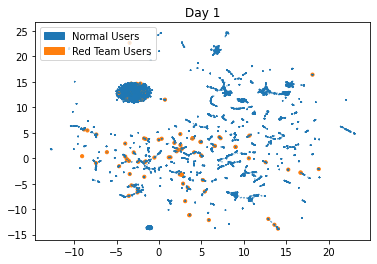

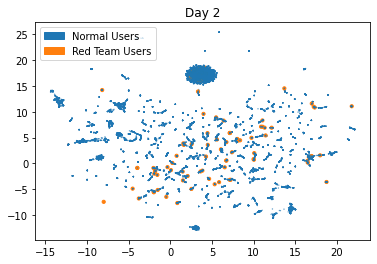

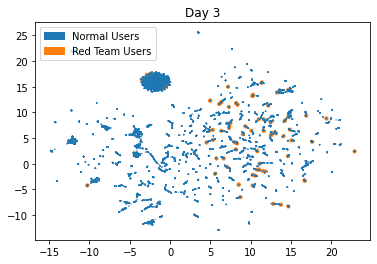

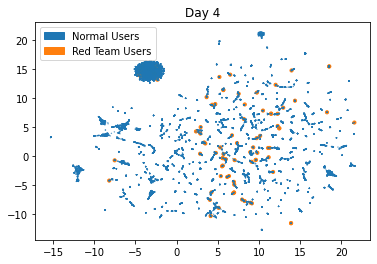

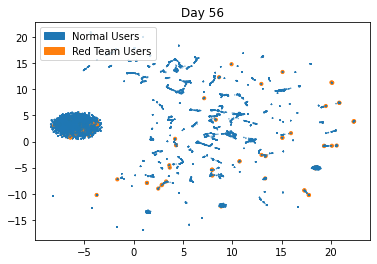

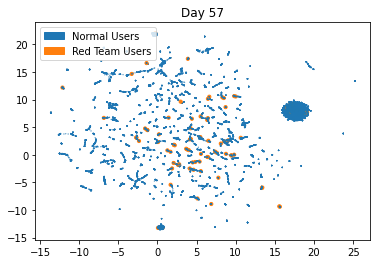

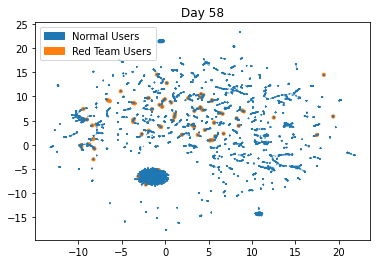

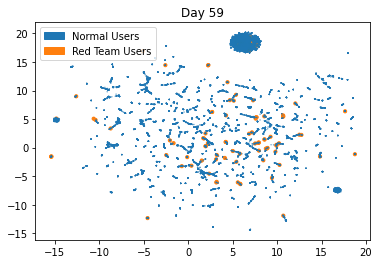

In [168]:
import warnings
from collections import defaultdict
warnings.filterwarnings("ignore", message="WARNING: spectral initialisation failed! ")
window_length=7
weeks = int(len(data_frame_list_uase)/window_length)

Y_arrays = []

for i in range(weeks):
    matrices = []
    for j in range(window_length):
        matrices.append(data_frame_list_uase[i*window_length+j])

    wl_matrix = scipy.sparse.hstack(matrices)

    u, s, v = scipy.sparse.linalg.svds(wl_matrix.asfptype(),k=7)

    for j in range(window_length):
        v_j = pd.DataFrame(v).iloc[: ,28815*j:28815*(j+1)]
        Y = pd.DataFrame((v_j.transpose()*s**0.5).transpose())
        Y_arrays.append(Y)

rt_bool = []
s = []
for un in list(columns_sparse):
    if un in rt_usernames:
        rt_bool.append(1)
        s.append(10)
    else:
        rt_bool.append(0)
        s.append(0.1)
        
print('Plotting.')
days = [0,1,2,3,55,56,57,58]
for d in days:
    embedding = reducer.fit_transform(np.array(Y_arrays[d]).transpose())
    fig = plt.figure()
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1],c=[sns.color_palette()[x] for x in rt_bool],s=s)
    plt.title('Day {}'.format(d+1))
    blu_patch = mpatches.Patch(color=sns.color_palette()[0], label='Normal Users')
    ora_patch = mpatches.Patch(color=sns.color_palette()[1], label='Red Team Users')
    plt.legend(handles=[blu_patch,ora_patch],loc='upper left')
    plt.show()
    if d == 57 or d == 1:
        fig.savefig('Day {} UMAP.png'.format(d+1))

### Combining Anomaly Detection Techniques

Our final anomalies are determined by the overlap of our poisson model and our autoencoder, combining two different data sets and two different anomaly detection methods in the hope that this reduces our false positive rate somewhat.

In [170]:
final_anomalies = pd.merge(anomalies_ae_5, poisson_anoms_inhom, how='inner', on=list(poisson_anoms.columns))
final_normal_anomalies = pd.merge(anomalies_ae_n_5, inhom_poisson_anoms_n, how='inner', on=list(poisson_anoms.columns))

In [171]:
final_anom_bool_n = []
final_anom_bool = []

for un in non_rt_sample:
    if un in list(final_normal_anomalies['UserName']):
        final_anom_bool_n.append((1,un))
    else:
        final_anom_bool_n.append((0,un))
for un in set(rt_usernames):
    if un in list(final_anomalies['UserName']):
        final_anom_bool.append((1,un))
    else:
        final_anom_bool.append((0,un))
simple_poiss_eval(final_anom_bool,final_anomalies,rt_usernames,'red team')
simple_poiss_eval(final_anom_bool_n,final_normal_anomalies,non_rt_sample,'normal')

94 of the red team usernames were identified to have anomalies out of 95 red team usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
User405399
25.50% of the red team data was identified as anomalous.
Authent Type
Batch                     335
CachedInteractive         164
InteractiveLogon          989
NetworkLogon            13080
RemoteInteractive         316
ScreensaverDismissed      472
ScreensaverInvoked        468
Service                   592
TGS                     15937
TGT                      3792
WorkstationLock          1134
WorkstationUnlock        1433
dtype: int64
179 of the normal usernames were identified to have anomalies out of 200 normal usernames. The folloiwng usernames were found to have no anomalies
--------------------------------------------------------------------------------------------
Comp792408$, Comp166939$, User835130, Comp982997$, Comp220136$, 

In [172]:
MCC(94,21,179,1)

(array([38.98305085, 34.43223443, 98.94736842, 89.5       ]),
 0.16803315759376639)

In [173]:
final_anomalies.to_csv('Final Anomalies (AE IPOIS).gz', compression='gzip')
final_normal_anomalies.to_csv('Final Normal Anomalies (AE IPOIS).gz', compression='gzip')

#### Checking that the random sample is a 'good sample'

Here we are just checking for the number of events each user has to determine if we captured enough of each bin.

In [174]:
full_check = np.array(list(authentication_data.groupby('UserName').size()))
sample_check = np.array(list(authentication_data[authentication_data['UserName'].isin(non_rt_sample)].groupby('UserName').size()))

In [175]:
def describe(data):
    mx = data.max()
    mn = data.min()
    mean = data.mean()
    median = np.median(data)
    q_25, q_75 = np.quantile(data,q=[0.25,0.75])
    std = np.std(data)
    return [mean,std,mn,q_25,median,q_75,mx]

In [176]:
a = describe(full_check)
b = describe(sample_check)
pd.DataFrame([a,b],columns = ['mean','std','min','25%','median','75%','max'],index=['Full Data Frame','Non Red Team Sample']).transpose()

,Full Data Frame,Non Red Team Sample
mean,553.658893,471.165000
std,3049.364235,459.627053
min,1.000000,1.000000
25%,119.000000,119.750000
median,403.000000,376.000000
75%,735.000000,642.000000
max,472595.000000,2667.000000


So as a check, we seem to get a good sample of the data using the non red team sample which is what we hoped to achieve. The mean of the sample is fairly close to the mean of , way within 1 std of the original mean and standard deviation. The other results are all very similar landing within +/- 10 of the full results roughly which is a good sign that it is a good representation. The maximum is way off but due to the outliers in the original data set this isn't unsurprising and likely has little effect on the results so we can assume they are fairly accurate. 

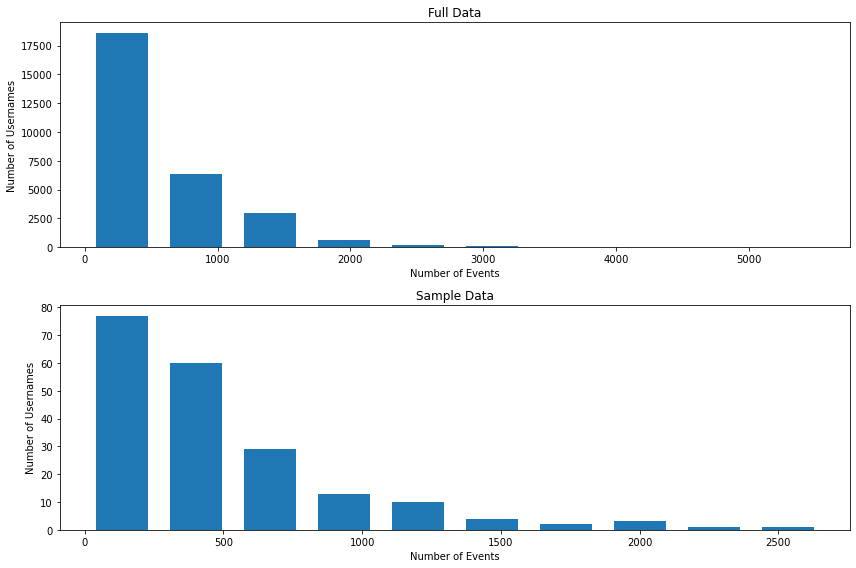

In [177]:
fig,ax = plt.subplots(2,1,figsize=(12,8))
ax[0].hist([i for i in full_check if i <= 6000],rwidth=0.7)
ax[1].hist(sample_check,rwidth=0.7)
ax[0].set_ylabel('Number of Usernames')
ax[0].set_xlabel('Number of Events')
ax[0].set_title('Full Data')
ax[1].set_ylabel('Number of Usernames')
ax[1].set_xlabel('Number of Events')
ax[1].set_title('Sample Data')
fig.tight_layout()
plt.show()
fig.savefig('C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/Number of Events.png')

Plotting histograms is a final sanity check for us. Since the highest results in the sample is ~6000 and the outliers in the full dataframe make the histograms almost incomprehensible, we limit the full check to a maximum of 6000 which encompases more than 99.9% of data. This shows that the distributions match almost exactly and is a really good sign that we got a good sample. 

Below, we check that each authentication type has been captured in the right distribution by our sample.

In [178]:
full_type_check_index = authentication_data.groupby('Authent Type').size().sort_values(ascending=False).index
full_type_check = np.array(list(authentication_data.groupby('Authent Type').size().sort_values(ascending=False)))

In [179]:
sample_type_check_index = authentication_data[authentication_data['UserName'].isin(non_rt_sample)].groupby('Authent Type').size().sort_values(ascending=False).index
sanple_type_check = np.array(list(authentication_data[authentication_data['UserName'].isin(non_rt_sample)].groupby('Authent Type').size().sort_values(ascending=False)))

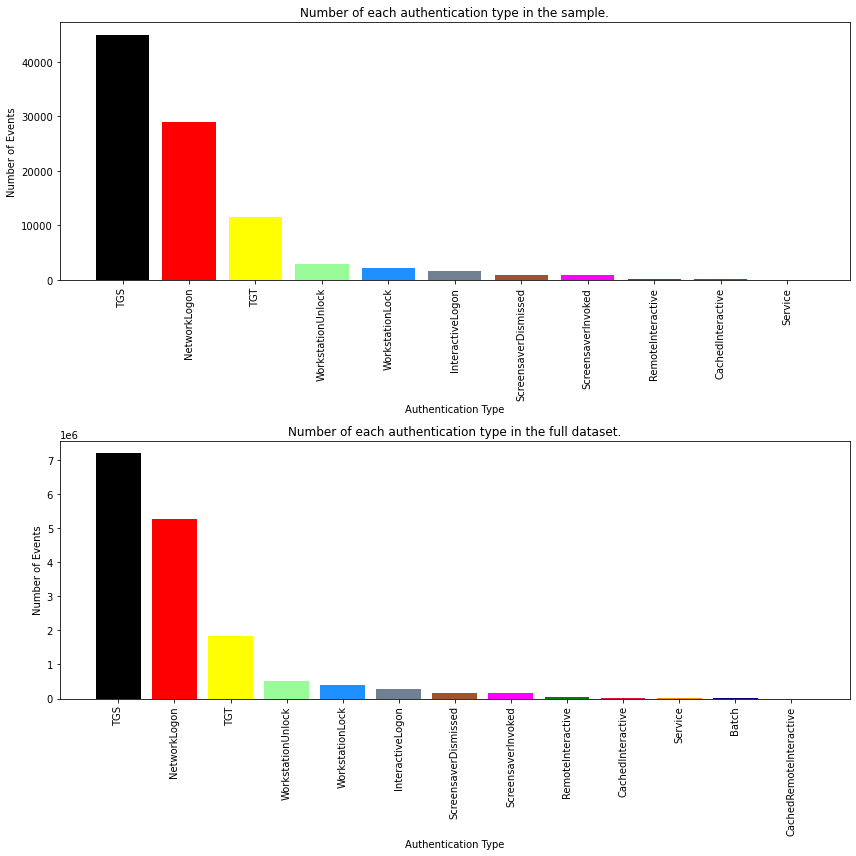

In [180]:
colors = ['black','red','yellow','palegreen','dodgerblue','slategrey','sienna','magenta','green','crimson','darkorange','navy','bisque']

fig,ax = plt.subplots(2,1,figsize=(12,12))
ax[0].bar(x=sample_type_check_index,height=sanple_type_check, color=colors)
ax[0].set_xlabel('Authentication Type')
ax[0].set_ylabel('Number of Events')
ax[0].set_title('Number of each authentication type in the sample.')

ax[1].bar(x=full_type_check_index,height=full_type_check, color=colors)
ax[1].set_xlabel('Authentication Type')
ax[1].set_ylabel('Number of Events')
ax[1].set_title('Number of each authentication type in the full dataset.')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.tight_layout()
fig.savefig('C:/Users/corri/OneDrive/Documents/Uni/Postgraduate/Final Project/Number of AT.png')
plt.show()

Similarly, the authentication types contained within the sample follow a very similar pattern to the full dataset with a few small differences in the ordering of the smaller authentication types. In general though the trend is correct.